
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_31207/3046165550.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


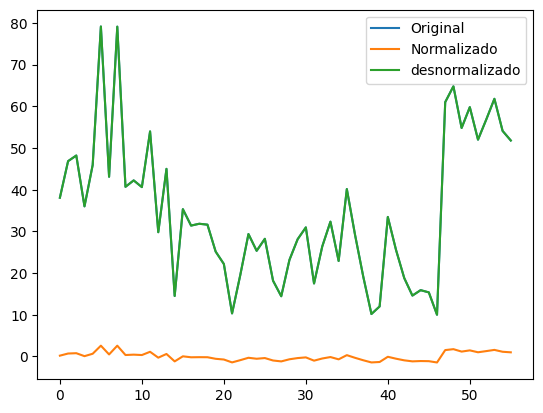

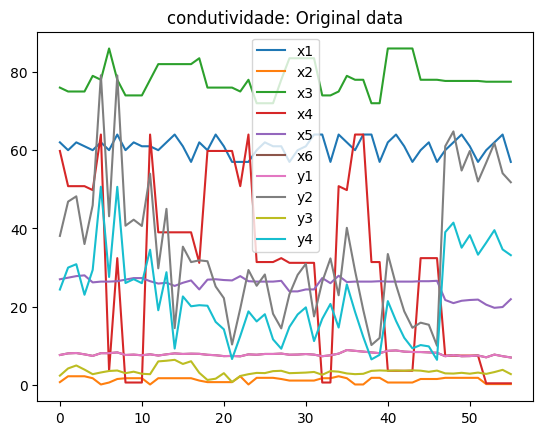

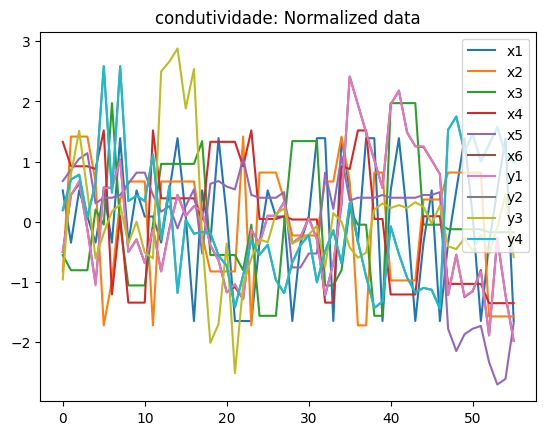

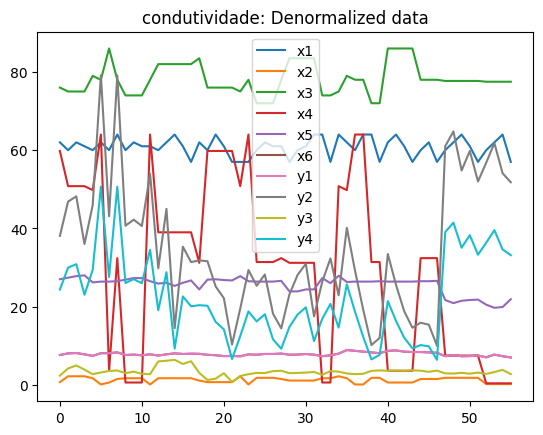

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 15:18:52.103783: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:18:52.140104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:18:52.140136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:18:52.141124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 15:18:52.147161: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:18:52.149379: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.6700304989999495
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.30759282999997595
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.21082824900008745
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.25125843499995426
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.23587831999998343
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.21430110200003583
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 7 +++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_2_0,0.801981,0.181911,0.846207,0.587757,58.303509,174.854326,58.069099,119.896567
model_2_2_1,0.813668,0.179270,0.834594,0.579635,54.862608,175.418657,62.453971,122.258817
model_2_2_2,0.822578,0.174605,0.823728,0.571182,52.239172,176.415774,66.556447,124.717283
model_2_2_3,0.829284,0.168459,0.813622,0.562617,50.264690,177.729353,70.372279,127.208375
model_2_2_4,0.834245,0.161262,0.804265,0.554100,48.803939,179.267598,73.905318,129.685358
model_2_2_5,0.837831,0.153360,0.795635,0.545753,47.748086,180.956742,77.163916,132.113066
model_2_2_6,0.840339,0.145031,0.787701,0.537666,47.009623,182.736732,80.159700,134.465175
model_2_2_17,0.840416,0.065141,0.735517,0.474703,46.987093,199.812028,99.863375,152.777346
model_2_2_16,0.841057,0.070463,0.738278,0.478461,46.798142,198.674680,98.820540,151.684471
model_2_2_15,0.841689,0.076211,0.741337,0.482565,46.612119,197.446189,97.665853,150.490722


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.26076390499997615
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.20215603399992688
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.2085561950000283
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.1771015179999722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.18991998899991813
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.23725836099993103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.31573884

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_18,0.801407,-0.676592,0.796369,0.324861,58.472612,304.300359,64.171129,191.298369
model_2_3_17,0.805384,-0.639589,0.800489,0.339566,57.301576,297.584254,62.872961,187.131891
model_2_3_16,0.809690,-0.599085,0.804978,0.355651,56.033751,290.232865,61.458069,182.574140
model_2_3_15,0.814333,-0.554847,0.809858,0.373207,54.666598,282.203658,59.920458,177.599797
model_2_3_14,0.819316,-0.506658,0.815143,0.392315,53.199424,273.457432,58.254882,172.185642
model_2_3_13,0.824633,-0.454330,0.820845,0.413045,51.634084,263.959871,56.457969,166.311920
model_2_3_12,0.830266,-0.397710,0.826970,0.435451,49.975552,253.683500,54.527842,159.963196
model_2_3_11,0.836183,-0.336714,0.833513,0.459560,48.233444,242.612721,52.465888,153.131865
model_2_3_10,0.842331,-0.271339,0.840460,0.485366,46.423058,230.747165,50.276552,145.819828
model_2_3_9,0.848635,-0.201690,0.847782,0.512818,44.566908,218.105969,47.969103,138.041555


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.2825089410000601
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.16245428799993533
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.24162684599991735
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.18296981200001028
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.27278190700008054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.26189477399998395
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.1680340

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_0,0.892189,0.904768,0.915590,0.924295,31.743297,25.899176,23.998865,25.004911
model_2_4_1,0.906282,0.905432,0.904729,0.920184,27.593651,25.718656,27.086853,26.362505
model_2_4_2,0.917177,0.905243,0.892889,0.915306,24.385823,25.770057,30.453073,27.973814
model_2_4_3,0.925530,0.904436,0.880494,0.909933,21.926414,25.989591,33.977079,29.748416
model_2_4_4,0.931866,0.903191,0.867873,0.904278,20.060989,26.328161,37.565317,31.616232
model_2_4_5,0.936604,0.901649,0.855281,0.898505,18.665835,26.747557,41.145280,33.522968
model_2_4_6,0.940082,0.899915,0.842914,0.892740,17.641780,27.218966,44.661377,35.427152
model_2_4_24,0.941270,0.875153,0.712471,0.829106,17.292202,33.953194,81.748121,56.444909
model_2_4_23,0.941692,0.875850,0.715688,0.830713,17.167912,33.763850,80.833355,55.914204
model_2_4_22,0.942139,0.876613,0.719230,0.832480,17.036154,33.556363,79.826348,55.330509


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.20521537600006923
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.16448023999987527
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.23314192599991657
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.2063434579999921
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.1742954250000821
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.21804351299988411
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.21171749

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_24,0.942228,0.206459,0.943459,0.720290,17.010015,90.774309,16.470567,55.807848
model_2_5_23,0.942992,0.217714,0.944275,0.724266,16.785150,89.486854,16.232917,55.014401
model_2_5_22,0.943820,0.230021,0.945173,0.728620,16.541226,88.079007,15.971057,54.145839
model_2_5_21,0.944716,0.243457,0.946163,0.733378,16.277408,86.542114,15.682771,53.196539
model_2_5_20,0.945682,0.258091,0.947252,0.738568,15.993105,84.867998,15.365634,52.160995
model_2_5_19,0.946718,0.273996,0.948448,0.744217,15.688016,83.048615,15.017243,51.033860
model_2_5_18,0.947825,0.291234,0.949760,0.750351,15.362229,81.076779,14.634903,49.810015
model_2_5_0,0.948523,0.757419,0.994446,0.922553,15.156501,27.749174,1.617972,15.452136
model_2_5_17,0.949000,0.309864,0.951199,0.756994,15.016283,78.945669,14.215866,48.484582
model_2_5_16,0.950239,0.329930,0.952773,0.764166,14.651464,76.650304,13.757353,47.053629


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.23310161299991705
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.1638361520001581
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.212241246000076
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.20711143099993023
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.22743624500003534
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.17695301599997038
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.246191506

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.947684,0.961117,0.630273,0.861104,15.403696,9.630756,45.621899,26.567772
model_2_6_1,0.951849,0.959525,0.624918,0.858387,14.177186,10.025110,46.282603,27.087458
model_2_6_2,0.954995,0.956797,0.619888,0.854990,13.250938,10.700694,46.903247,27.737190
model_2_6_3,0.957337,0.953270,0.615234,0.851160,12.561590,11.574337,47.477579,28.469971
model_2_6_24,0.958785,0.883974,0.576294,0.791834,12.135142,28.737787,52.282482,39.817633
model_2_6_23,0.958982,0.885476,0.576835,0.793027,12.077015,28.365879,52.215786,39.589391
model_2_6_4,0.959045,0.949205,0.610969,0.847078,12.058631,12.581115,48.003842,29.250640
model_2_6_22,0.959194,0.887124,0.577435,0.794339,12.014616,27.957773,52.141724,39.338451
model_2_6_21,0.959421,0.888930,0.578101,0.795780,11.947983,27.510439,52.059561,39.062969
model_2_6_20,0.959661,0.890906,0.578840,0.797359,11.877270,27.021020,51.968312,38.760933


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.20206305100009558
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.23923865300002944
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.23594223700001749
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.23543467799981954
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.2379868489999808
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.24869558600016717
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.2255315

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_24,0.950292,0.550707,0.871571,0.716334,14.635666,72.112047,21.095619,48.104319
model_2_7_23,0.950757,0.554336,0.873737,0.719140,14.498882,71.529699,20.739812,47.628578
model_2_7_22,0.951267,0.558348,0.876131,0.722241,14.348655,70.885713,20.346711,47.102652
model_2_7_21,0.951826,0.562780,0.878772,0.725666,14.183981,70.174319,19.912838,46.521857
model_2_7_20,0.952438,0.567672,0.881685,0.729444,14.003836,69.389286,19.434414,45.881109
model_2_7_19,0.953106,0.573062,0.884892,0.733607,13.807258,68.524125,18.907499,45.175130
model_2_7_18,0.953832,0.578994,0.888419,0.738187,13.593373,67.572042,18.328167,44.398449
model_2_7_17,0.954620,0.585510,0.892291,0.743217,13.361463,66.526206,17.692180,43.545491
model_2_7_16,0.955470,0.592651,0.896532,0.748728,13.111106,65.380013,16.995648,42.610902
model_2_7_15,0.956383,0.600457,0.901164,0.754751,12.842244,64.127233,16.234812,41.589622


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.28338335500006906
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.18013009700007387
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.23168533800003388
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.15408605299990086
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.2035031519999393
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.3338218019998749
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.20921062

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_24,0.957336,0.453321,0.827819,0.741777,12.561715,44.709877,37.231974,41.190863
model_2_8_23,0.957897,0.460312,0.830625,0.745465,12.396568,44.138090,36.625119,40.602575
model_2_8_22,0.958508,0.468014,0.833709,0.749523,12.216660,43.508231,35.958203,39.955262
model_2_8_21,0.959172,0.476489,0.837094,0.753983,12.021190,42.815080,35.226307,39.243901
model_2_8_20,0.959891,0.485804,0.840803,0.758877,11.809452,42.053275,34.424205,38.463115
model_2_8_19,0.960667,0.496027,0.844862,0.764241,11.580917,41.217142,33.546640,37.607508
model_2_8_18,0.961502,0.507234,0.849294,0.770110,11.335214,40.300627,32.588200,36.671248
model_2_8_17,0.962394,0.519494,0.854125,0.776520,11.072372,39.297893,31.543610,35.648815
model_2_8_16,0.963344,0.532884,0.859377,0.783505,10.792802,38.202836,30.407876,34.534628
model_2_8_0,0.963941,0.893476,0.989502,0.964389,10.616919,8.712043,2.270033,5.680503


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.22160425899983238
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.23226017299998603
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.21022791199993662
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.3012011849998544
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.2595860910000738
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.1792472969998471
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.156700995

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.965234,0.998238,0.997765,0.998031,10.236286,0.525936,0.590365,0.556256
model_2_9_1,0.971431,0.996258,0.997857,0.996964,8.411761,1.117047,0.566104,0.857778
model_2_9_2,0.976256,0.993697,0.997643,0.995437,6.991166,1.881471,0.622537,1.289030
model_2_9_3,0.979977,0.990722,0.997170,0.993566,5.895472,2.769232,0.747452,1.817804
model_2_9_4,0.982815,0.987475,0.996488,0.991449,5.059996,3.738647,0.927718,2.415858
model_2_9_5,0.984948,0.984069,0.995645,0.989173,4.431830,4.755105,1.150365,3.058756
model_2_9_6,0.986524,0.980601,0.994687,0.986811,3.967861,5.790430,1.403381,3.725933
model_2_9_24,0.987575,0.940828,0.979971,0.958090,3.658210,17.662262,5.290044,11.840037
model_2_9_7,0.987661,0.977145,0.993654,0.984424,3.633091,6.822048,1.676237,4.400491
model_2_9_23,0.987744,0.941836,0.980403,0.958844,3.608536,17.361304,5.175993,11.627037


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.7940996279999126
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.1703638179999416
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.24604893400010042
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.24208014300006653
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.18156639199992242
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.17953628000009303
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_15,0.815482,-0.162657,0.555332,0.288199,54.328573,240.048511,109.589162,178.655865
model_3_2_14,0.815810,-0.158966,0.555226,0.289757,54.231844,239.286443,109.615245,178.264742
model_3_2_13,0.816157,-0.154902,0.555071,0.291455,54.129625,238.447384,109.653463,177.838506
model_3_2_12,0.816520,-0.150434,0.554851,0.293299,54.022664,237.524969,109.707634,177.375644
model_3_2_11,0.816896,-0.145530,0.554548,0.295295,53.912026,236.512406,109.782292,176.874703
model_3_2_10,0.817279,-0.140152,0.554139,0.297448,53.799190,235.402191,109.883245,176.334492
model_3_2_9,0.817663,-0.134270,0.553593,0.299757,53.686354,234.187560,110.017791,175.754713
model_3_2_0,0.817827,-0.053515,0.532336,0.325103,53.637983,217.514515,115.256545,169.393135
model_3_2_8,0.818036,-0.127843,0.552874,0.302224,53.576429,232.860615,110.195024,175.135658
model_3_2_7,0.818386,-0.120838,0.551934,0.304840,53.473387,231.414498,110.426543,174.478975


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.25405123200016533
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.22063984300007178
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.25292880000006335
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.233059755000113
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.2641280820000702
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.2139895370000886
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.1901192720

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.875440,0.969647,0.994247,0.986465,36.674656,6.588718,2.733928,4.774702
model_3_3_1,0.894240,0.942505,0.990532,0.975267,31.139496,12.480484,4.499543,8.724750
model_3_3_2,0.907795,0.910117,0.985875,0.961764,27.148286,19.510773,6.712758,13.488187
model_3_3_24,0.910377,0.457891,0.893171,0.755669,26.388226,117.675526,50.769134,86.190158
model_3_3_23,0.911395,0.464492,0.894968,0.758958,26.088301,116.242604,49.915014,85.029615
model_3_3_22,0.912498,0.471814,0.896943,0.762596,25.763449,114.653135,48.976587,83.746510
model_3_3_21,0.913689,0.479934,0.899109,0.766614,25.412937,112.890681,47.946969,82.328924
model_3_3_20,0.914968,0.488935,0.901483,0.771052,25.036297,110.936826,46.818783,80.763617
model_3_3_19,0.916335,0.498909,0.904080,0.775947,24.633722,108.771791,45.584860,79.036759
model_3_3_3,0.917333,0.875032,0.980550,0.946958,24.340087,27.126829,9.243506,18.711145


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.23799750199987102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.22313371599989296
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.2052574150000055
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.271208814999909
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.19255296400001498
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.28327383900000314
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.268525846

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.926229,0.983550,0.975682,0.982215,21.720764,8.436396,3.165832,5.956130
model_3_4_1,0.938765,0.982442,0.974883,0.981171,18.029791,9.004173,3.269966,6.305723
model_3_4_2,0.948640,0.980859,0.973138,0.979568,15.122169,9.816160,3.497021,6.842449
model_3_4_3,0.956384,0.978944,0.970662,0.977562,12.842190,10.798365,3.819379,7.514141
model_3_4_4,0.962422,0.976813,0.967633,0.975281,11.064313,11.891016,4.213765,8.278197
model_3_4_5,0.967099,0.974560,0.964203,0.972827,9.687163,13.046535,4.660275,9.100053
model_3_4_6,0.970693,0.972257,0.960505,0.970283,8.629048,14.227804,5.141692,9.951992
model_3_4_7,0.973427,0.969958,0.956650,0.967714,7.824109,15.406546,5.643541,10.812191
model_3_4_8,0.975480,0.967706,0.952732,0.965171,7.219419,16.561716,6.153717,11.663844
model_3_4_9,0.976998,0.965529,0.948825,0.962692,6.772434,17.678063,6.662304,12.494179


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.22465288100011094
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.31775889999994433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.1810255740001594
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.21981985699994766
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.22432028100001844
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.1803775759999553
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.24819088

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_24,0.961164,0.959957,0.577822,0.852417,11.434635,10.168519,68.481588,37.609991
model_3_5_23,0.961596,0.960568,0.582408,0.854113,11.307485,10.013400,67.737667,37.177761
model_3_5_22,0.962070,0.961238,0.587466,0.855982,11.167925,9.843136,66.917220,36.701516
model_3_5_21,0.962589,0.961973,0.593040,0.858040,11.014957,9.656493,66.013015,36.177223
model_3_5_20,0.963158,0.962777,0.599176,0.860302,10.847599,9.452269,65.017769,35.600744
model_3_5_19,0.963779,0.963656,0.605923,0.862786,10.664814,9.229186,63.923217,34.967539
model_3_5_18,0.964455,0.964613,0.613334,0.865511,10.465684,8.986137,62.721185,34.273202
model_3_5_17,0.965190,0.965653,0.621460,0.868494,10.249325,8.722000,61.403068,33.513103
model_3_5_16,0.965986,0.966780,0.630356,0.871753,10.014926,8.435855,59.959938,32.682459
model_3_5_15,0.966845,0.967997,0.640076,0.875306,9.761958,8.126922,58.383221,31.776935


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.27594226499991237
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.20422214499990332
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.2312326060000487
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.21728702199993677
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.20132787299985466
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.17821084399997744
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.2113478

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.969491,0.998768,0.266966,0.934334,8.982975,0.383977,43.236932,20.550072
model_3_6_1,0.971179,0.998226,0.267399,0.934087,8.485761,0.552735,43.211372,20.627383
model_3_6_2,0.972499,0.997648,0.266873,0.933735,8.097237,0.732924,43.242429,20.737397
model_3_6_3,0.973524,0.997052,0.265655,0.933313,7.795420,0.918394,43.314292,20.869400
model_3_6_4,0.974315,0.996455,0.263954,0.932848,7.562600,1.104466,43.414582,21.015101
model_3_6_5,0.974919,0.995867,0.261933,0.932358,7.384598,1.287710,43.533824,21.168237
model_3_6_6,0.975377,0.995296,0.259717,0.931861,7.249949,1.465600,43.664483,21.323904
model_3_6_7,0.975718,0.994748,0.257402,0.931367,7.149511,1.636372,43.801082,21.478583
model_3_6_8,0.975968,0.994227,0.255058,0.930884,7.075937,1.798802,43.939320,21.629635
model_3_6_24,0.976139,0.989554,0.230382,0.926232,7.025595,3.254749,45.394787,23.085359


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.21163738699988244
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.167967057000169
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.2641733739999381
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.18205374000012853
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.20020180899996376
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3294369390000611
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.2224189819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.978472,0.988644,0.950201,0.971223,6.338510,3.900067,15.947096,9.569262
model_3_7_1,0.980210,0.987436,0.948564,0.969820,5.826996,4.314839,16.471487,10.035622
model_3_7_2,0.981480,0.986169,0.946719,0.968292,5.453006,4.749768,17.062081,10.543792
model_3_7_24,0.981608,0.969963,0.918346,0.946572,5.415275,10.315429,26.148057,17.766079
model_3_7_23,0.981713,0.970215,0.918833,0.946931,5.384274,10.228949,25.992263,17.646969
model_3_7_22,0.981827,0.970493,0.919369,0.947326,5.350727,10.133312,25.820455,17.515491
model_3_7_21,0.981950,0.970801,0.919961,0.947762,5.314530,10.027582,25.631026,17.370377
model_3_7_20,0.982082,0.971141,0.920612,0.948244,5.275664,9.910740,25.422544,17.210408
model_3_7_19,0.982223,0.971517,0.921328,0.948773,5.234158,9.781821,25.193238,17.034258
model_3_7_18,0.982373,0.971931,0.922114,0.949356,5.190099,9.639562,24.941510,16.840472


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.208374928000012
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.21625188799998796
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.18767647999993642
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.2017416010000943
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.21394145599992953
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.2152483510001275
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.2152088969

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.983286,0.959072,0.998471,0.968424,4.921046,17.015527,0.110950,9.060430
model_3_8_1,0.984543,0.958784,0.996247,0.967938,4.551099,17.135141,0.272359,9.199717
model_3_8_2,0.985468,0.958444,0.992503,0.967232,4.278675,17.276411,0.544116,9.402390
model_3_8_24,0.985829,0.952903,0.902417,0.952259,4.172377,19.580193,7.082182,13.698770
model_3_8_23,0.985900,0.952999,0.904133,0.952537,4.151383,19.540067,6.957640,13.618931
model_3_8_22,0.985978,0.953105,0.906022,0.952843,4.128693,19.495888,6.820516,13.531003
model_3_8_21,0.986060,0.953223,0.908099,0.953180,4.104277,19.447182,6.669791,13.434296
model_3_8_3,0.986135,0.958073,0.987729,0.966379,4.082417,17.430690,0.890591,9.647116
model_3_8_20,0.986149,0.953351,0.910381,0.953551,4.078119,19.393651,6.504199,13.328028
model_3_8_19,0.986244,0.953493,0.912883,0.953957,4.050250,19.334777,6.322637,13.211415


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.21489094699995803
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.29452253099998416
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.2538787470000443
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.1697059470000113
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.23236122799994519
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.16230666599994947
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.20519819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.979213,0.909784,0.947897,0.934183,6.120386,19.053866,21.258519,20.091339
model_3_9_23,0.979561,0.911421,0.948786,0.935342,6.017933,18.708031,20.895550,19.737446
model_3_9_22,0.979942,0.913222,0.949765,0.936618,5.905908,18.327709,20.496193,19.348177
model_3_9_21,0.980357,0.915200,0.950841,0.938019,5.783639,17.909907,20.057245,18.920419
model_3_9_20,0.980809,0.917370,0.952022,0.939556,5.650554,17.451663,19.575609,18.451168
model_3_9_19,0.981300,0.919746,0.953315,0.941240,5.506068,16.949810,19.047817,17.937129
model_3_9_18,0.981831,0.922343,0.954730,0.943081,5.349717,16.401374,18.470479,17.375075
model_3_9_17,0.982403,0.925176,0.956275,0.945090,5.181153,15.803124,17.840259,16.761773
model_3_9_16,0.983017,0.928257,0.957957,0.947277,5.000232,15.152238,17.153804,16.094160
model_3_9_15,0.983674,0.931600,0.959785,0.949651,4.807077,14.446170,16.408162,15.369456


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.49723812599995654
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.1871467159999156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.21185055999990254
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.20682537400011825
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.27145604299994375
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.22033002600005602
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_22,0.816664,0.061757,-1.039758,-0.174982,53.980481,178.779094,174.245270,176.645520
model_4_5_0,0.817656,0.534118,0.779293,0.628376,53.688416,88.772333,18.853822,55.869501
model_4_5_21,0.818412,0.068237,-1.006997,-0.161875,53.465785,177.544424,171.446706,174.674933
model_4_5_20,0.820304,0.075408,-0.970884,-0.147406,52.908566,176.177877,168.361754,172.499725
model_4_5_19,0.822346,0.083344,-0.931108,-0.131445,52.307428,174.665708,164.963933,170.100151
model_4_5_18,0.824539,0.092123,-0.887356,-0.113856,51.661854,172.992972,161.226443,167.455783
model_4_5_17,0.826882,0.101826,-0.839274,-0.094488,50.972005,171.144036,157.119038,164.544074
model_4_5_16,0.829370,0.112551,-0.786512,-0.073184,50.239320,169.100544,152.611896,161.341200
model_4_5_15,0.831993,0.124394,-0.728707,-0.049779,49.467026,166.843779,147.673915,157.822623
model_4_5_1,0.832394,0.489439,0.675895,0.570749,49.348944,97.285622,27.686498,64.533078


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.273400810999874
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.21107918000006975
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.2557119939999666
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.15946493100000225
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.23254996800005756
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.21362614600002416
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.252525979

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.876307,0.981283,0.978406,0.979281,36.419543,3.689565,11.215578,7.231232
model_4_6_1,0.895761,0.976725,0.969492,0.971676,30.691406,4.588161,15.844844,9.885434
model_4_6_2,0.910212,0.971235,0.958001,0.961987,26.436774,5.670315,21.813277,13.266983
model_4_6_24,0.919844,0.871650,0.739649,0.779301,23.600737,25.301288,135.219355,77.027457
model_4_6_3,0.920748,0.965187,0.944848,0.950968,23.334423,6.862559,28.644571,17.112907
model_4_6_23,0.920923,0.873673,0.743756,0.782782,23.282853,24.902462,133.086043,75.812414
model_4_6_22,0.922086,0.875886,0.748273,0.786607,22.940542,24.466162,130.740351,74.477528
model_4_6_21,0.923332,0.878304,0.753232,0.790803,22.573632,23.989589,128.164428,73.013037
model_4_6_20,0.924661,0.880940,0.758672,0.795400,22.182420,23.469961,125.339405,71.408516
model_4_6_19,0.926068,0.883808,0.764628,0.800429,21.767975,22.904523,122.245810,69.653442


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.2230040839999674
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.3085086539999793
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.21928734099992653
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.2396616520002226
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.22728093800014904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.21651502800000344
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.248451881

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.934766,0.962587,0.986433,0.970433,19.207037,18.787081,3.713260,11.693514
model_4_7_1,0.946690,0.967886,0.989266,0.974918,15.696257,16.126130,2.937819,9.919875
model_4_7_2,0.956191,0.972185,0.990372,0.978168,12.898754,13.967201,2.635176,8.634491
model_4_7_3,0.963737,0.975658,0.990151,0.980430,10.677176,12.223571,2.695765,7.739896
model_4_7_4,0.969704,0.978447,0.988927,0.981906,8.920090,10.822827,3.030637,7.155909
model_4_7_5,0.974401,0.980674,0.986965,0.982764,7.537084,9.704676,3.567640,6.816672
model_4_7_6,0.978077,0.982438,0.984477,0.983140,6.454758,8.818635,4.248513,6.667988
model_4_7_7,0.980934,0.983825,0.981635,0.983146,5.613565,8.122515,5.026509,6.665569
model_4_7_8,0.983136,0.984903,0.978573,0.982874,4.965222,7.581161,5.864475,6.773318
model_4_7_9,0.984816,0.985731,0.975399,0.982397,4.470602,7.165280,6.733239,6.961960


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.2110097750000932
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.2694557940001232
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.18467046499995377
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.18613826699993297
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.1707571790000202
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.1844840829999157
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.2234712970

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.990228,0.992856,0.999171,0.995108,2.877134,1.726525,0.118767,0.969933
model_4_8_1,0.991683,0.991745,0.998200,0.994062,2.448729,1.994835,0.257869,1.177438
model_4_8_24,0.992244,0.956634,0.971516,0.962333,2.283712,10.479859,4.081514,7.468880
model_4_8_23,0.992345,0.957261,0.971963,0.962890,2.254025,10.328205,4.017447,7.358436
model_4_8_22,0.992454,0.957952,0.972456,0.963503,2.221851,10.161276,3.946834,7.236829
model_4_8_21,0.992572,0.958712,0.972999,0.964179,2.187076,9.977618,3.869008,7.102981
model_4_8_20,0.992699,0.959546,0.973597,0.964920,2.149654,9.775936,3.783330,6.955900
model_4_8_2,0.992733,0.990163,0.996862,0.992586,2.139690,2.377147,0.449645,1.470090
model_4_8_19,0.992835,0.960462,0.974254,0.965734,2.109578,9.554755,3.689171,6.794481
model_4_8_18,0.992980,0.961464,0.974975,0.966627,2.066891,9.312454,3.585790,6.617561


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.2771151590000045
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.2585022480000134
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.24403092900001866
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.20326123300014842
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.25200793100020746
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.19355137599995942
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.17303498

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.982782,0.938386,0.939989,0.943215,5.069663,19.607832,13.386435,16.680114
model_4_9_23,0.983000,0.939346,0.940514,0.943953,5.005247,19.302300,13.269297,16.463238
model_4_9_22,0.983241,0.940404,0.941093,0.944767,4.934465,18.965668,13.140219,16.224295
model_4_9_21,0.983505,0.941568,0.941730,0.945662,4.856783,18.595198,12.998105,15.961269
model_4_9_20,0.983794,0.942847,0.942430,0.946646,4.771708,18.188065,12.841890,15.672212
model_4_9_19,0.984110,0.944251,0.943199,0.947727,4.678666,17.741130,12.670290,15.354850
model_4_9_18,0.984454,0.945791,0.944043,0.948911,4.577153,17.251315,12.482217,15.007032
model_4_9_17,0.984830,0.947474,0.944966,0.950206,4.466655,16.715543,12.276252,14.626463
model_4_9_16,0.985237,0.949312,0.945974,0.951621,4.346724,16.130591,12.051334,14.210937
model_4_9_15,0.985678,0.951314,0.947073,0.953162,4.216982,15.493553,11.806125,13.758295


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.46726654200006124
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.2649841310001193
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.15298130999985915
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.22906459099999665
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.15901194899993243
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.20349466200013921
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_0,0.808739,0.981247,0.938710,0.962090,56.313878,3.779263,13.838554,8.513041
model_5_2_1,0.836446,0.959119,0.890842,0.928927,48.155769,8.238587,24.646487,15.959947
model_5_2_2,0.856343,0.930123,0.842190,0.892131,42.297678,14.081996,35.631410,24.222897
model_5_2_3,0.871015,0.899482,0.798497,0.856899,37.977578,20.257070,45.496754,32.134561
model_5_2_4,0.881845,0.870073,0.759069,0.824270,34.788913,26.183760,54.399037,39.461537
model_5_2_23,0.886922,0.580473,0.401893,0.517675,33.294134,84.546033,135.044548,108.310019
model_5_2_22,0.888199,0.587622,0.409384,0.524616,32.918111,83.105251,133.353205,106.751348
model_5_2_21,0.889554,0.595418,0.417645,0.532229,32.519066,81.534059,131.488106,105.041832
model_5_2_5,0.889734,0.842877,0.723064,0.794312,32.466207,31.664603,62.528517,46.188797
model_5_2_20,0.890982,0.603904,0.426744,0.540566,32.098756,79.824081,129.433462,103.169643


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.25744647800001985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.20743614299999535
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.19841715100005786
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.302744703000144
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.2444221790001393
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.21039263200009373
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.213750099

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.907324,0.850845,0.993712,0.956492,27.287044,17.871684,2.011009,10.407840
model_5_3_24,0.912045,0.373935,0.700407,0.645498,25.896964,75.014691,95.813949,84.802575
model_5_3_23,0.913160,0.383990,0.704141,0.650514,25.568706,73.809955,94.619820,83.602820
model_5_3_22,0.914378,0.395060,0.708300,0.656065,25.209948,72.483591,93.289916,82.274793
model_5_3_21,0.915707,0.407231,0.712930,0.662206,24.818815,71.025200,91.808993,80.805808
model_5_3_20,0.917152,0.420596,0.718089,0.668996,24.393405,69.423898,90.158960,79.181579
model_5_3_19,0.918718,0.435244,0.723840,0.676498,23.932134,67.668771,88.319920,77.386956
model_5_3_18,0.920411,0.451266,0.730251,0.684780,23.433796,65.749008,86.269491,75.405694
model_5_3_1,0.921791,0.857888,0.983319,0.951821,23.027549,17.027792,5.334973,11.525288
model_5_3_17,0.922231,0.468748,0.737401,0.693914,22.897783,63.654266,83.982799,73.220660


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.35462650499994197
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.2576225870000144
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.20202724199998556
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.15520046500000717
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.21575280100000782
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.1807419059998665
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.24240020

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.925999,0.982722,0.977188,0.980530,21.788397,8.389737,9.810318,9.058243
model_5_4_1,0.936759,0.980786,0.972184,0.977283,18.620346,9.329970,11.962665,10.568881
model_5_4_2,0.944978,0.978460,0.966779,0.973646,16.200230,10.459529,14.286829,12.260605
model_5_4_3,0.951182,0.975882,0.961143,0.969770,14.373748,11.711364,16.710730,14.064007
model_5_4_4,0.955789,0.973162,0.955402,0.965770,13.017187,13.031710,19.179565,15.924813
model_5_4_24,0.958345,0.937843,0.881296,0.914016,12.264589,30.182312,51.049815,40.002309
model_5_4_23,0.958782,0.938580,0.882915,0.915128,12.135933,29.824429,50.353175,39.485000
model_5_4_5,0.959138,0.970388,0.949657,0.961738,12.031103,14.378752,21.650446,17.800716
model_5_4_22,0.959249,0.939391,0.884695,0.916351,11.998370,29.430509,49.588050,38.916428
model_5_4_21,0.959746,0.940283,0.886646,0.917692,11.852116,28.997202,48.748963,38.292162


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.21271132899983058
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.21218722499997966
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.15625421699996878
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.2820354000000407
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.24095368600001166
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.19087295200006338
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.2170145

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.963151,0.949099,0.944033,0.948279,10.849718,22.839676,7.191156,15.475666
model_5_5_24,0.965603,0.893434,0.869055,0.888933,10.127746,47.817454,16.825046,33.232798
model_5_5_23,0.965887,0.894401,0.870318,0.889956,10.044013,47.383453,16.662805,32.926674
model_5_5_22,0.966196,0.895466,0.871709,0.891083,9.952990,46.905379,16.483992,32.589428
model_5_5_21,0.966531,0.896639,0.873241,0.892323,9.854358,46.379426,16.287142,32.218347
model_5_5_1,0.966624,0.947659,0.941772,0.946678,9.827095,23.485957,7.481661,15.954532
model_5_5_20,0.966893,0.897927,0.874926,0.893686,9.747839,45.801402,16.070617,31.810443
model_5_5_19,0.967282,0.899341,0.876777,0.895183,9.633263,45.166958,15.832787,31.362651
model_5_5_18,0.967698,0.900890,0.878808,0.896823,9.510678,44.471992,15.571919,30.871964
model_5_5_17,0.968141,0.902584,0.881031,0.898617,9.380264,43.711831,15.286298,30.335103


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.22962448499993116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.19993253899997399
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2722662539999874
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.20112933599989447
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.2565513879999344
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.2664277899998524
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.304350522

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.929834,0.922183,0.631663,0.798719,20.659419,27.320938,113.609502,67.927302
model_5_6_23,0.930620,0.923210,0.635810,0.801068,20.427838,26.960472,112.330367,67.134585
model_5_6_22,0.931490,0.924345,0.640421,0.803677,20.171772,26.561855,110.908062,66.254218
model_5_6_21,0.932451,0.925600,0.645549,0.806573,19.888860,26.121425,109.326480,65.276765
model_5_6_20,0.933511,0.926985,0.651251,0.809788,19.576509,25.635101,107.567760,64.191650
model_5_6_19,0.934682,0.928513,0.657592,0.813357,19.231958,25.098645,105.611983,62.987299
model_5_6_18,0.935972,0.930198,0.664644,0.817318,18.852156,24.507235,103.436747,61.650534
model_5_6_17,0.937392,0.932053,0.672487,0.821713,18.433963,23.855789,101.017547,60.167215
model_5_6_16,0.938953,0.934093,0.681206,0.826587,17.974322,23.139508,98.328369,58.522543
model_5_6_15,0.940666,0.936334,0.690894,0.831988,17.469952,22.352844,95.340337,56.699898


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.2275657439997758
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.22928138199995374
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.24914005199980238
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.16740013200001158
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.25230222300001515
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3197746860000734
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.16271209

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.941168,0.934352,0.958763,0.955227,17.322258,19.121142,12.620427,16.061993
model_5_7_1,0.949776,0.939828,0.956053,0.956493,14.787619,17.525997,13.449825,15.607777
model_5_7_2,0.956280,0.943461,0.951817,0.956354,12.872606,16.467955,14.746211,15.657717
model_5_7_3,0.961157,0.945736,0.946634,0.955251,11.436673,15.805155,16.332677,16.053410
model_5_7_4,0.964775,0.947012,0.940913,0.953503,10.371490,15.433702,18.083391,16.680610
model_5_7_5,0.967419,0.947551,0.934948,0.951340,9.593106,15.276514,19.909133,17.456555
model_5_7_24,0.969135,0.933112,0.865545,0.917270,9.087623,19.482276,41.149795,29.678760
model_5_7_6,0.969310,0.947555,0.928943,0.948931,9.036129,15.275288,21.746827,18.320732
model_5_7_23,0.969379,0.933635,0.867045,0.918097,9.015819,19.329809,40.690649,29.381956
model_5_7_22,0.969639,0.934206,0.868702,0.919008,8.939250,19.163624,40.183506,29.055329


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.1789765040000475
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.2535972580001271
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.15511781899999733
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.1633532710000054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.19624434600018503
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.17178642099997887
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.174736257

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.967261,0.781568,0.937279,0.859182,9.639440,46.576382,14.898910,31.669341
model_5_8_23,0.967509,0.783123,0.938035,0.860339,9.566444,46.244731,14.719176,31.409173
model_5_8_22,0.967780,0.784842,0.938866,0.861615,9.486732,45.878199,14.521803,31.122257
model_5_8_21,0.968075,0.786741,0.939777,0.863021,9.399871,45.473245,14.305477,30.806060
model_5_8_20,0.968395,0.788837,0.940774,0.864568,9.305485,45.026370,14.068669,30.458037
model_5_8_19,0.968743,0.791149,0.941863,0.866270,9.203204,44.533366,13.809988,30.075311
model_5_8_18,0.969118,0.793697,0.943049,0.868139,9.092802,43.990202,13.528124,29.655101
model_5_8_17,0.969521,0.796501,0.944340,0.870188,8.974100,43.392212,13.221605,29.194279
model_5_8_16,0.969952,0.799584,0.945738,0.872430,8.847152,42.734819,12.889421,28.689929
model_5_8_15,0.970410,0.802969,0.947249,0.874880,8.712165,42.012939,12.530628,28.138910


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.290978295000059
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.233177957999942
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.16502507100017283
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.19104082000012568
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.2627539549998801
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.18477610800005095
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.23003996400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.973710,0.996480,0.878402,0.954174,7.740758,1.771834,38.655497,19.128853
model_5_9_24,0.974733,0.985296,0.862648,0.941389,7.439450,7.400984,43.663463,24.465679
model_5_9_23,0.974826,0.985486,0.862973,0.941627,7.412228,7.305304,43.560247,24.366453
model_5_9_1,0.974866,0.996036,0.878616,0.953968,7.400402,1.995085,38.587411,19.214988
model_5_9_22,0.974926,0.985695,0.863331,0.941889,7.382639,7.199978,43.446533,24.257189
model_5_9_21,0.975035,0.985925,0.863724,0.942177,7.350588,7.084203,43.321491,24.137044
model_5_9_20,0.975152,0.986178,0.864156,0.942493,7.315999,6.957065,43.184203,24.005131
model_5_9_19,0.975279,0.986455,0.864629,0.942839,7.278831,6.817686,43.033704,23.860513
model_5_9_18,0.975414,0.986758,0.865148,0.943218,7.239082,6.665113,42.868896,23.702183
model_5_9_17,0.975557,0.987089,0.865714,0.943633,7.196855,6.498453,42.688996,23.529272


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.4439828580000267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.20293579100007264
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.20967934800000876
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.1820632009998917
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.21024957800000266
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.2240875339998638
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_0,0.801021,0.619931,0.914658,0.732841,58.586216,147.183203,20.274007,87.461236
model_6_3_1,0.820975,0.623934,0.900908,0.730651,52.711037,145.633339,23.540615,88.177934
model_6_3_2,0.836915,0.627314,0.887456,0.728175,48.017762,144.324134,26.736158,88.988613
model_6_3_3,0.849596,0.630112,0.874417,0.725475,44.284167,143.240636,29.833800,89.872718
model_6_3_4,0.859638,0.632389,0.861876,0.722617,41.327416,142.359080,32.813191,90.808077
model_6_3_5,0.867553,0.634216,0.849898,0.719671,38.997070,141.651470,35.658727,91.772530
model_6_3_6,0.873758,0.635665,0.838531,0.716698,37.169900,141.090143,38.359011,92.746072
model_6_3_7,0.878596,0.636802,0.827807,0.713747,35.745538,140.649987,40.906615,93.711927
model_6_3_8,0.882342,0.637681,0.817741,0.710861,34.642632,140.309384,43.297800,94.656878
model_6_3_9,0.885219,0.638352,0.808338,0.708070,33.795432,140.049753,45.531736,95.570690


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.21642997599997216
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.20659598999986883
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.16746056700003464
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.16757892299983723
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.24266220799995608
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.19372717000010198
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.250229

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.902512,0.718198,0.510962,0.660671,28.703794,64.625886,127.446624,94.188567
model_6_4_23,0.903646,0.723668,0.515215,0.664943,28.369869,63.371347,126.338297,93.002865
model_6_4_22,0.904880,0.729673,0.519892,0.669636,28.006545,61.994177,125.119451,91.700186
model_6_4_0,0.906151,0.990315,0.738552,0.880250,27.632414,2.220967,68.135216,33.239444
model_6_4_21,0.906219,0.736256,0.525028,0.674785,27.612389,60.484532,123.780938,90.271078
model_6_4_20,0.907666,0.743460,0.530660,0.680424,27.186191,58.832464,122.313114,88.705711
model_6_4_19,0.909225,0.751328,0.536825,0.686589,26.727209,57.028167,120.706475,86.994416
model_6_4_18,0.910896,0.759901,0.543560,0.693315,26.235226,55.062071,118.951285,85.127579
model_6_4_17,0.912677,0.769218,0.550901,0.700634,25.710835,52.925296,117.038278,83.096114
model_6_4_16,0.914563,0.779315,0.558879,0.708575,25.155658,50.609810,114.959031,80.891778


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2713466069999413
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.15684724100015046
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.2220430730001226
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.18959347000009075
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.26131293699995695
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.2609067660000619
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.182709984

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.918172,0.958197,0.650289,0.761000,24.093005,7.301961,133.495319,66.687066
model_6_5_1,0.921345,0.953444,0.656480,0.763410,23.158624,8.132179,131.132094,66.014488
model_6_5_2,0.923826,0.948591,0.661524,0.765049,22.428130,8.979946,129.206651,65.557218
model_6_5_3,0.925756,0.943748,0.665643,0.766096,21.859983,9.825771,127.634251,65.265050
model_6_5_4,0.927247,0.939002,0.669014,0.766693,21.420934,10.654890,126.347630,65.098529
model_6_5_5,0.928391,0.934413,0.671777,0.766951,21.084257,11.456516,125.292723,65.026476
model_6_5_6,0.929259,0.930024,0.674047,0.766958,20.828592,12.223014,124.426304,65.024572
model_6_5_7,0.929910,0.925866,0.675915,0.766782,20.636801,12.949415,123.713409,65.073654
model_6_5_8,0.930391,0.921954,0.677454,0.766476,20.495204,13.632755,123.125795,65.158898
model_6_5_9,0.930739,0.918296,0.678725,0.766082,20.392886,14.271625,122.640698,65.268847


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  1.0419244180000078
Stopped at epoch:  31
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.2848144689999117
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.23376042899985805
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.1807712199999969
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.1725817899998674
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.2666264229999342
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.2139661490

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.940273,0.494909,0.815622,0.696268,17.585545,70.457410,43.832862,57.928192
model_6_6_23,0.940299,0.495288,0.815595,0.696400,17.577986,70.404505,43.839150,57.903149
model_6_6_22,0.940328,0.495709,0.815566,0.696545,17.569603,70.345739,43.846149,57.875342
model_6_6_21,0.940359,0.496177,0.815533,0.696707,17.560308,70.280540,43.853935,57.844480
model_6_6_20,0.940394,0.496697,0.815497,0.696887,17.549979,70.208034,43.862557,57.810160
model_6_6_19,0.940433,0.497273,0.815456,0.697086,17.538561,70.127692,43.872276,57.772201
model_6_6_18,0.940476,0.497912,0.815411,0.697308,17.525870,70.038474,43.882862,57.729961
model_6_6_17,0.940524,0.498622,0.815361,0.697553,17.511819,69.939446,43.894735,57.683122
model_6_6_16,0.940577,0.499409,0.815306,0.697826,17.496254,69.829603,43.907985,57.631187
model_6_6_15,0.940635,0.500283,0.815244,0.698128,17.479030,69.707789,43.922670,57.573608


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.23925082400000974
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.16511495100007778
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.23641687200006345
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.1520790429999579
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.2245746460000646
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.28221621099987715
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.18665693

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.948503,0.885965,0.986243,0.955658,15.162357,23.488691,7.225087,15.835231
model_6_7_1,0.954854,0.889548,0.983352,0.954751,13.292479,22.750510,8.743452,16.158952
model_6_7_2,0.959721,0.891642,0.980289,0.953271,11.859523,22.319327,10.351889,16.687589
model_6_7_3,0.963418,0.892645,0.977154,0.951407,10.771108,22.112591,11.998776,17.353148
model_6_7_4,0.966194,0.892866,0.974019,0.949305,9.953674,22.067080,13.644975,18.103740
model_6_7_5,0.968249,0.892537,0.970942,0.947075,9.348693,22.134884,15.261156,18.900191
model_6_7_6,0.969740,0.891834,0.967962,0.944798,8.909543,22.279785,16.825887,19.713247
model_6_7_24,0.970169,0.875858,0.938585,0.919589,8.783233,25.570398,32.254860,28.716036
model_6_7_23,0.970343,0.876317,0.939270,0.920203,8.732053,25.475962,31.894679,28.496539
model_6_7_22,0.970528,0.876821,0.940027,0.920881,8.677633,25.372061,31.497080,28.254433


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.20287001099995905
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.2524000299999898
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.18394227399994634
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.2315882140001122
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.21592720300009205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.26230175999990024
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.23898184

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.974926,0.978352,0.994910,0.985251,7.382730,9.152221,1.625202,5.610084
model_6_8_1,0.978603,0.978207,0.995177,0.985271,6.300108,9.213616,1.540056,5.602526
model_6_8_2,0.981425,0.977545,0.995203,0.984891,5.469242,9.493637,1.531705,5.746845
model_6_8_3,0.983571,0.976521,0.995058,0.984232,4.837165,9.926504,1.577785,5.997690
model_6_8_4,0.985187,0.975257,0.994796,0.983384,4.361552,10.460902,1.661717,6.320109
model_6_8_5,0.986385,0.973846,0.994453,0.982419,4.008641,11.057534,1.770982,6.687391
model_6_8_6,0.987258,0.972358,0.994061,0.981388,3.751548,11.686580,1.896289,7.079382
model_6_8_24,0.987618,0.954588,0.988510,0.968739,3.645753,19.199242,3.668556,11.890684
model_6_8_23,0.987716,0.955038,0.988661,0.969063,3.616769,19.009019,3.620421,11.767326
model_6_8_22,0.987821,0.955534,0.988827,0.969420,3.585980,18.799469,3.567499,11.631483


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.2468391149998297
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.21735287500018785
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.24159135700006118
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.21920075299999553
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.22711099899993314
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2316356049998376
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.16999494

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.991326,0.958908,0.986212,0.978008,2.553787,11.144479,5.299126,8.393729
model_6_9_23,0.991379,0.959125,0.986347,0.978153,2.538235,11.085518,5.247253,8.338104
model_6_9_22,0.991437,0.959365,0.986496,0.978314,2.521287,11.020583,5.190136,8.276843
model_6_9_21,0.991499,0.959629,0.986659,0.978491,2.502848,10.949029,5.127313,8.209400
model_6_9_20,0.991567,0.959919,0.986839,0.978685,2.482851,10.870332,5.058280,8.135254
model_6_9_19,0.991641,0.960238,0.987036,0.978898,2.461236,10.783864,4.982561,8.053836
model_6_9_18,0.991720,0.960587,0.987252,0.979132,2.437971,10.688991,4.899645,7.964588
model_6_9_17,0.991804,0.960970,0.987488,0.979388,2.413052,10.585098,4.808977,7.866933
model_6_9_0,0.991829,0.972924,0.993976,0.986959,2.405882,7.343307,2.315380,4.977220
model_6_9_16,0.991895,0.961389,0.987745,0.979667,2.386496,10.471501,4.710043,7.760228


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.6943198769999981
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.2899462190000577
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.24390567499995086
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.21570307100000718
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.2116627560001234
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.2190913009999349
Stopped at epoch:  6
1/1 [==============================] - 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_12,0.801162,0.329759,0.488186,0.445198,58.544618,156.501742,226.413304,189.401296
model_7_4_11,0.802750,0.335350,0.496148,0.452078,58.077261,155.196073,222.890896,187.052478
model_7_4_10,0.804363,0.341419,0.504861,0.459589,57.602170,153.778974,219.036529,184.488365
model_7_4_0,0.804665,0.424668,0.640554,0.572479,57.513471,134.340406,159.009363,145.949341
model_7_4_9,0.805969,0.347981,0.514373,0.467765,57.129312,152.246844,214.828817,181.697205
model_7_4_8,0.807522,0.355043,0.524729,0.476637,56.672228,150.597886,210.247594,178.668332
model_7_4_1,0.808311,0.415610,0.622922,0.558447,56.439816,136.455367,166.809426,150.739641
model_7_4_7,0.808958,0.362601,0.535967,0.486227,56.249380,148.833060,205.275844,175.394376
model_7_4_6,0.810195,0.370636,0.548122,0.496549,55.885083,146.956726,199.899183,171.870768
model_7_4_2,0.810458,0.406356,0.606131,0.544857,55.807658,138.616180,174.237246,155.379046


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.4120822249999492
Stopped at epoch:  13
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.26107045100002324
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.26568793299998106
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.2272723969999788
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.19161516700000902
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.29446585400000913
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.2608840

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.884528,0.924945,0.419553,0.643041,33.998889,12.357022,178.870410,90.716238
model_7_5_1,0.887749,0.914040,0.419813,0.639450,33.050424,14.152400,178.790294,91.629035
model_7_5_2,0.890182,0.903564,0.419817,0.635859,32.334044,15.877203,178.789026,92.541555
model_7_5_3,0.891994,0.893617,0.419621,0.632335,31.800769,17.514777,178.849509,93.437026
model_7_5_4,0.893317,0.884262,0.419271,0.628928,31.411242,19.054980,178.957294,94.303078
model_7_5_24,0.893575,0.799084,0.409899,0.594366,31.335247,33.078679,181.845259,103.086508
model_7_5_23,0.893707,0.800516,0.410140,0.594994,31.296402,32.842889,181.771123,102.926762
model_7_5_22,0.893848,0.802104,0.410403,0.595689,31.254699,32.581425,181.689936,102.750143
model_7_5_21,0.894000,0.803864,0.410692,0.596458,31.210141,32.291737,181.600910,102.554916
model_7_5_20,0.894160,0.805813,0.411006,0.597306,31.162857,31.970788,181.504080,102.339339


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.21341589899998326
Stopped at epoch:  6
1/1 [==============================] - 0s 72ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.26399144999982127
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.2981855699999869
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.23599114800003917
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.2577753099999427
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.24521873300000152
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.25878596

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.910456,0.982817,0.752602,0.943712,26.364704,6.090889,21.287077,13.242036
model_7_6_1,0.923267,0.977781,0.739354,0.937414,22.592691,7.876362,22.426961,14.723703
model_7_6_2,0.932957,0.970612,0.726454,0.929476,19.739868,10.417364,23.536925,16.591277
model_7_6_3,0.940232,0.962208,0.714351,0.920688,17.597642,13.396566,24.578354,18.658590
model_7_6_4,0.945629,0.953135,0.703105,0.911515,16.008636,16.612823,25.546001,20.816672
model_7_6_24,0.948498,0.824639,0.591405,0.789788,15.163859,62.161936,35.157070,49.453765
model_7_6_23,0.949044,0.827588,0.593659,0.792528,15.003309,61.116584,34.963151,48.809082
model_7_6_5,0.949558,0.943757,0.692658,0.902236,14.851939,19.937098,26.444874,22.999590
model_7_6_22,0.949625,0.830818,0.596130,0.795530,14.832233,59.971611,34.750551,48.102892
model_7_6_21,0.950240,0.834349,0.598837,0.798813,14.651108,58.719868,34.517585,47.330557


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.24611217899996518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.2072911689999728
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.3046943059998739
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.20241184099995735
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.21599549100005788
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.27949195900009727
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.26555479

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.957361,0.999118,0.974498,0.990812,12.554530,0.227671,4.163583,2.079865
model_7_7_1,0.964114,0.997289,0.965228,0.986562,10.565929,0.699669,5.677147,3.042013
model_7_7_2,0.969228,0.994707,0.955326,0.981643,9.060376,1.366053,7.293762,4.155568
model_7_7_3,0.973066,0.991598,0.945407,0.976400,7.930422,2.168671,8.913293,5.342611
model_7_7_4,0.975911,0.988153,0.935801,0.971060,7.092571,3.057877,10.481615,6.551400
model_7_7_5,0.977986,0.984528,0.926674,0.965774,6.481642,3.993517,11.971699,7.747946
model_7_7_24,0.978780,0.940000,0.842037,0.910171,6.247992,15.486434,25.790155,20.335236
model_7_7_23,0.978995,0.941007,0.843712,0.911348,6.184688,15.226346,25.516704,20.068871
model_7_7_22,0.979224,0.942118,0.845564,0.912646,6.117118,14.939794,25.214374,19.774884
model_7_7_6,0.979464,0.980843,0.918102,0.960641,6.046598,4.944486,13.371171,8.909986


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.22550218199990013
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.33025769100004254
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.2262985079998998
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.26415392800004156
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.2743073459998868
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.27145445700011805
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.23032385

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_24,0.975870,0.942545,0.793811,0.880871,7.104681,12.176482,35.911133,23.345739
model_7_8_23,0.976105,0.942798,0.796410,0.882104,7.035486,12.122704,35.458412,23.104216
model_7_8_22,0.976362,0.943075,0.799272,0.883459,6.959940,12.064104,34.959870,22.838588
model_7_8_21,0.976641,0.943376,0.802421,0.884948,6.877635,12.000394,34.411418,22.546755
model_7_8_20,0.976945,0.943702,0.805882,0.886583,6.788174,11.931194,33.808690,22.226493
model_7_8_19,0.977274,0.944055,0.809679,0.888373,6.691259,11.856398,33.147365,21.875684
model_7_8_18,0.977630,0.944435,0.813839,0.890330,6.586627,11.775773,32.422850,21.492047
model_7_8_17,0.978012,0.944844,0.818389,0.892467,6.474112,11.689174,31.630455,21.073307
model_7_8_16,0.978421,0.945280,0.823355,0.894794,6.353726,11.596681,30.765594,20.617344
model_7_8_15,0.978856,0.945745,0.828762,0.897321,6.225638,11.498286,29.823861,20.122082


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.212675728000022
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.21114770899998803
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.26762659800010624
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.23241202799999883
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.2503847349998978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2384544989999995
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.2342597530

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.978570,0.867265,0.959622,0.920959,6.309730,16.723299,7.946306,12.592958
model_7_9_1,0.980691,0.874540,0.959830,0.924126,5.685255,15.806668,7.905477,12.088466
model_7_9_2,0.982349,0.879992,0.959677,0.926320,5.197055,15.119745,7.935516,11.738931
model_7_9_3,0.983638,0.884014,0.959263,0.927762,4.817564,14.613080,8.017116,11.509100
model_7_9_4,0.984633,0.886919,0.958663,0.928630,4.524537,14.247106,8.135051,11.370842
model_7_9_5,0.985395,0.888956,0.957940,0.929062,4.300152,13.990350,8.277509,11.301967
model_7_9_6,0.985973,0.890327,0.957138,0.929170,4.130037,13.817706,8.435315,11.284825
model_7_9_7,0.986405,0.891186,0.956294,0.929039,4.002705,13.709421,8.601373,11.305634
model_7_9_8,0.986724,0.891659,0.955435,0.928738,3.908977,13.649880,8.770396,11.353629
model_7_9_9,0.986953,0.891843,0.954581,0.928319,3.841508,13.626699,8.938436,11.420466


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.5397289779998573
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.22434137499999451
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.21113584599993374
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.2182899140000245
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.17422271800001
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.2526879029999236
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.800424,0.987825,0.978501,0.984117,58.762023,4.787763,6.475922,5.582185
model_8_3_1,0.833963,0.982913,0.965634,0.976017,48.886922,6.719295,10.352049,8.428826
model_8_3_2,0.859533,0.976523,0.947440,0.964893,41.358375,9.232427,15.832507,12.338343
model_8_3_3,0.878679,0.969084,0.924851,0.951376,35.721153,12.157575,22.636759,17.088952
model_8_3_4,0.892723,0.961006,0.899110,0.936209,31.585973,15.334412,30.390641,22.419708
model_8_3_5,0.902803,0.952655,0.871670,0.920195,28.618183,18.618103,38.656278,28.047834
model_8_3_24,0.908770,0.862455,0.586350,0.751685,26.861106,54.088932,124.601813,87.271486
model_8_3_23,0.909688,0.864317,0.591900,0.755026,26.590929,53.356604,122.930070,86.097080
model_8_3_6,0.909869,0.944335,0.843939,0.904081,26.537540,21.890022,47.009580,33.710985
model_8_3_22,0.910665,0.866376,0.598041,0.758722,26.303166,52.547277,121.080052,84.798003


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.28006551499993293
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.22158091300002525
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.27327682999998615
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.2074924789999386
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.1958317700000407
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.22775175900005706
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.28926821

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.922825,0.717078,0.988356,0.917716,22.722920,38.708347,4.855183,22.777445
model_8_4_1,0.933878,0.731254,0.987229,0.920627,19.468527,36.768782,5.325064,21.971739
model_8_4_2,0.942570,0.742791,0.985061,0.922109,16.909283,35.190351,6.229244,21.561593
model_8_4_3,0.949398,0.752343,0.982207,0.922585,14.898877,33.883572,7.418936,21.429627
model_8_4_4,0.954752,0.760359,0.978933,0.922362,13.322603,32.786755,8.784400,21.491532
model_8_4_5,0.958938,0.767160,0.975429,0.921658,12.090205,31.856303,10.245142,21.686343
model_8_4_6,0.962198,0.772977,0.971838,0.920634,11.130246,31.060494,11.742493,21.969674
model_8_4_7,0.964725,0.777983,0.968261,0.919408,10.386097,30.375586,13.234274,22.309084
model_8_4_8,0.966672,0.782311,0.964767,0.918065,9.812781,29.783429,14.690851,22.681034
model_8_4_9,0.968161,0.786066,0.961407,0.916665,9.374466,29.269697,16.091928,23.068395


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  1.21723186600002
Stopped at epoch:  36
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.22190250999983618
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.250273548999985
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.19427721400006703
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.20803869900009886
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.30652147299997523
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.2707935500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.983099,0.972495,0.946109,0.954376,4.976198,5.845612,28.256841,16.392079
model_8_5_23,0.983100,0.972498,0.946110,0.954378,4.976025,5.845020,28.256260,16.391483
model_8_5_22,0.983100,0.972501,0.946111,0.954380,4.975832,5.844345,28.255598,16.390818
model_8_5_21,0.983101,0.972505,0.946113,0.954382,4.975620,5.843608,28.254868,16.390084
model_8_5_20,0.983102,0.972509,0.946114,0.954384,4.975391,5.842798,28.254085,16.389286
model_8_5_19,0.983103,0.972513,0.946116,0.954387,4.975134,5.841869,28.253217,16.388383
model_8_5_18,0.983104,0.972518,0.946118,0.954389,4.974848,5.840839,28.252224,16.387372
model_8_5_17,0.983105,0.972523,0.946120,0.954392,4.974536,5.839726,28.251115,16.386256
model_8_5_16,0.983106,0.972529,0.946122,0.954396,4.974186,5.838469,28.249857,16.385003
model_8_5_15,0.983107,0.972535,0.946125,0.954400,4.973814,5.837103,28.248510,16.383647


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.2147383720000562
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.21421606800004156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.22859913399997822
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.24990151999986665
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.24748687199985397
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.23554922900007114
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.2280880

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.985986,0.999732,0.992857,0.996414,4.126178,0.068554,2.160731,1.053108
model_8_6_1,0.988217,0.999328,0.991693,0.995664,3.469434,0.171741,2.512912,1.273467
model_8_6_2,0.989921,0.998726,0.990314,0.994718,2.967623,0.325621,2.930097,1.551262
model_8_6_3,0.991206,0.997987,0.988785,0.993637,2.589297,0.514263,3.392622,1.868781
model_8_6_4,0.992158,0.997162,0.987163,0.992471,2.308813,0.725096,3.883198,2.211261
model_8_6_24,0.992837,0.985528,0.965509,0.976615,2.109011,3.698119,10.433539,6.867731
model_8_6_5,0.992850,0.996289,0.985497,0.991261,2.105335,0.948237,4.387255,2.566599
model_8_6_23,0.992917,0.985765,0.965960,0.976944,2.085394,3.637378,10.296874,6.771258
model_8_6_22,0.993003,0.986028,0.966458,0.977306,2.060098,3.570294,10.146271,6.664872
model_8_6_21,0.993095,0.986318,0.967006,0.977705,2.033159,3.496270,9.980497,6.547667


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.2080178710000382
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.24223064299985708
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.23559096500002852
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.27495057900000575
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.27088543700006085
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.18124809599999026
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.2784721

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.993790,0.987893,0.997143,0.991700,1.828402,2.948427,0.530634,1.810642
model_8_7_1,0.994496,0.987069,0.997067,0.991183,1.620455,3.149050,0.544617,1.923434
model_8_7_24,0.994839,0.972484,0.983627,0.977180,1.519470,6.700866,3.040507,4.978346
model_8_7_23,0.994888,0.972714,0.983896,0.977424,1.505242,6.644867,2.990477,4.925152
model_8_7_22,0.994940,0.972968,0.984192,0.977693,1.489825,6.583076,2.935475,4.866559
model_8_7_21,0.994997,0.973247,0.984517,0.977988,1.473174,6.514928,2.875111,4.802071
model_8_7_2,0.995009,0.986148,0.996713,0.990497,1.469508,3.373314,0.610400,2.073118
model_8_7_20,0.995057,0.973555,0.984874,0.978313,1.455273,6.439893,2.808926,4.731205
model_8_7_19,0.995122,0.973894,0.985264,0.978669,1.436127,6.357366,2.736541,4.653448
model_8_7_18,0.995192,0.974267,0.985689,0.979060,1.415755,6.266631,2.657492,4.568214


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.33267916400018294
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.21622952999996414
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.19660675799991623
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.21778882199987493
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.2772891370000252
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.22123891399996864
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.2378573

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.995443,0.990891,0.994971,0.993501,1.341791,1.690194,1.841596,1.761437
model_8_8_1,0.995912,0.990421,0.994953,0.993318,1.203660,1.777459,1.848341,1.810817
model_8_8_2,0.996274,0.989930,0.994899,0.993106,1.097032,1.868480,1.868168,1.868334
model_8_8_3,0.996551,0.989434,0.994819,0.992876,1.015439,1.960592,1.897283,1.930798
model_8_8_4,0.996761,0.988942,0.994723,0.992636,0.953672,2.051818,1.932631,1.995735
model_8_8_5,0.996918,0.988463,0.994615,0.992394,0.907554,2.140766,1.971930,2.061312
model_8_8_6,0.997033,0.988002,0.994502,0.992155,0.873733,2.226337,2.013377,2.126124
model_8_8_24,0.997088,0.983515,0.993108,0.989642,0.857297,3.058782,2.523890,2.807067
model_8_8_23,0.997101,0.983620,0.993145,0.989704,0.853474,3.039354,2.510541,2.790495
model_8_8_7,0.997115,0.987562,0.994387,0.991922,0.849531,2.307888,2.055635,2.189182


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.308827385000086
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.30045186100005594
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.20602042699988488
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.2576841830000376
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.22333033199993224
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.24179062199982582
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.239366373

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.997558,0.996116,0.997103,0.996575,0.719038,1.153413,0.742217,0.959909
model_8_9_1,0.997918,0.996413,0.997387,0.996864,0.613134,1.065213,0.669258,0.878881
model_8_9_2,0.998190,0.996594,0.997545,0.997034,0.532879,1.011395,0.628909,0.831401
model_8_9_3,0.998394,0.996688,0.997605,0.997112,0.472875,0.983603,0.613377,0.809381
model_8_9_4,0.998544,0.996716,0.997594,0.997123,0.428792,0.975278,0.616443,0.806413
model_8_9_24,0.998595,0.995074,0.995197,0.995171,0.413593,1.462888,1.230380,1.353473
model_8_9_23,0.998610,0.995124,0.995266,0.995229,0.409322,1.447983,1.212784,1.337300
model_8_9_22,0.998625,0.995179,0.995341,0.995292,0.404741,1.431707,1.193525,1.319623
model_8_9_21,0.998642,0.995239,0.995423,0.995361,0.399854,1.413938,1.172505,1.300323
model_8_9_5,0.998651,0.996695,0.997528,0.997083,0.397177,0.981290,0.633177,0.817472


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.48515643699988686
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.4352340790001108
Stopped at epoch:  12
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.23447409999994306
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.22521981299996696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2106228090001423
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.21730186099989623
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_1_24,0.807631,0.487869,-0.456826,0.359560,56.639984,236.456962,130.312457,186.506591
model_9_1_23,0.807915,0.488956,-0.456201,0.360562,56.556510,235.955275,130.256556,186.214698
model_9_1_22,0.808227,0.490161,-0.455520,0.361673,56.464679,235.398502,130.195663,185.891275
model_9_1_21,0.808569,0.491500,-0.454781,0.362903,56.363745,234.780487,130.129508,185.532988
model_9_1_20,0.808946,0.492985,-0.453980,0.364265,56.252994,234.094878,130.057878,185.136291
model_9_1_19,0.809357,0.494632,-0.453117,0.365772,56.131700,233.334509,129.980665,184.697407
model_9_1_18,0.809808,0.496459,-0.452189,0.367440,55.999005,232.490927,129.897668,184.211730
model_9_1_17,0.810300,0.498485,-0.451198,0.369284,55.854200,231.555460,129.809007,183.674764
model_9_1_16,0.810835,0.500731,-0.450145,0.371321,55.696539,230.518341,129.714810,183.081383
model_9_1_15,0.811417,0.503221,-0.449033,0.373572,55.525354,229.368913,129.615401,182.426100


DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Elapsed time:  0.31283041599999706
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Elapsed time:  0.24847689800003536
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Elapsed time:  0.28499343199996474
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Elapsed time:  0.2845424230001754
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Elapsed time:  0.32172397099998307
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Elapsed time:  0.252313594999805
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Elapsed time:  0.185209092

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.832078,0.921189,0.770631,0.831385,49.442081,19.236135,95.387697,55.072166
model_9_2_1,0.850214,0.908942,0.763229,0.822104,44.102276,22.225237,98.466152,58.103307
model_9_2_2,0.863404,0.894232,0.753382,0.810384,40.218571,25.815769,102.561175,61.931269
model_9_2_24,0.867765,0.585555,0.621792,0.609415,38.934465,101.157253,157.285668,127.570612
model_9_2_23,0.868508,0.590610,0.622956,0.612112,38.715747,99.923372,156.801606,126.689593
model_9_2_22,0.869320,0.596225,0.624284,0.615130,38.476780,98.552980,156.249294,125.704193
model_9_2_21,0.870204,0.602458,0.625802,0.618505,38.216357,97.031560,155.617891,124.601592
model_9_2_20,0.871165,0.609376,0.627542,0.622284,37.933414,95.343103,154.894623,123.367357
model_9_2_19,0.872205,0.617049,0.629537,0.626516,37.627130,93.470225,154.064748,121.985317
model_9_2_3,0.872683,0.877114,0.742101,0.796852,37.486368,29.993838,107.252657,66.350943


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.29430606500000067
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.2235181249998277
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.21018769400006931
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.19006602300032682
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.2549044219999814
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.2103617839998151
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.311117845

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.893832,0.996691,0.992060,0.995362,31.259590,0.778068,0.991082,0.878308
model_9_3_1,0.912248,0.989898,0.973005,0.984987,25.837316,2.375326,3.369677,2.843259
model_9_3_2,0.925209,0.981545,0.933677,0.967299,22.020986,4.339297,8.278717,6.193144
model_9_3_3,0.934278,0.972638,0.884441,0.946173,19.350898,6.433736,14.424657,10.194175
model_9_3_24,0.935330,0.842794,0.276183,0.672168,19.041007,36.964569,90.350496,62.087371
model_9_3_23,0.936164,0.845651,0.286435,0.677226,18.795476,36.292808,89.070779,61.129508
model_9_3_22,0.937060,0.848778,0.297733,0.682786,18.531657,35.557432,87.660424,60.076480
model_9_3_21,0.938018,0.852195,0.310176,0.688891,18.249614,34.754083,86.107291,58.920306
model_9_3_20,0.939036,0.855920,0.323867,0.695586,17.949773,33.878030,84.398260,57.652298
model_9_3_19,0.940112,0.859974,0.338921,0.702919,17.633186,32.924998,82.519213,56.263442


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.1880435570001282
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.23112605000005715
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.26669656900003247
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.2849270550000256
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.23868991400013329
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.2730615109999235
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.179935360

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.873587,-0.170933,0.928618,0.560903,37.220366,212.029163,21.426227,122.333659
model_9_4_23,0.876070,-0.147546,0.930252,0.569779,36.489277,207.794169,20.935859,119.860849
model_9_4_22,0.878795,-0.121779,0.932043,0.579553,35.686804,203.128448,20.398193,117.137739
model_9_4_21,0.881781,-0.093436,0.934003,0.590299,34.807798,197.996081,19.809949,114.143778
model_9_4_20,0.885042,-0.062319,0.936141,0.602090,33.847482,192.361642,19.168243,110.858864
model_9_4_19,0.888595,-0.028232,0.938466,0.614998,32.801349,186.189258,18.470340,107.262705
model_9_4_18,0.892451,0.009003,0.940984,0.629087,31.666000,179.446750,17.714446,103.337416
model_9_4_17,0.896618,0.049545,0.943699,0.644413,30.439215,172.105519,16.899485,99.067396
model_9_4_16,0.901096,0.093512,0.946609,0.661017,29.120710,164.144174,16.026012,94.441503
model_9_4_15,0.905878,0.140968,0.949706,0.678917,27.712788,155.550903,15.096486,89.454709


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.23832028300012098
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.19563075599990043
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.21801871099978598
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.2519395109998186
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.24954571000034775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.2600256010000521
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.35198701

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.896469,0.944547,0.992462,0.970040,30.483008,9.277487,1.477505,5.606910
model_9_5_1,0.914409,0.947109,0.985866,0.968002,25.200976,8.848957,2.770205,5.988355
model_9_5_2,0.928428,0.947853,0.977057,0.964012,21.073202,8.724508,4.496916,6.735051
model_9_5_3,0.939290,0.947079,0.966166,0.958279,17.875171,8.853959,6.631543,7.808116
model_9_5_4,0.947577,0.945001,0.953260,0.950935,15.434987,9.201584,9.161099,9.182537
model_9_5_24,0.948288,0.814776,0.640990,0.735401,15.225672,30.988891,70.366382,49.519469
model_9_5_23,0.949028,0.818652,0.646683,0.740041,15.007916,30.340418,69.250514,48.651058
model_9_5_22,0.949821,0.822882,0.652991,0.745152,14.774487,29.632767,68.014299,47.694663
model_9_5_21,0.950668,0.827493,0.659997,0.750787,14.524958,28.861246,66.640965,46.639932
model_9_5_20,0.951572,0.832520,0.667812,0.757017,14.258808,28.020298,65.109276,45.473961


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.7937850220000655
Stopped at epoch:  22
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.27148311600012676
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.25748874500004604
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.20566283299967836
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.23794693500030917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.18985969999994268
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.223806

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.970666,0.723050,0.944567,0.847700,8.636965,43.008452,12.067320,28.447933
model_9_6_23,0.970685,0.723237,0.944606,0.847803,8.631309,42.979367,12.058853,28.428538
model_9_6_22,0.970706,0.723445,0.944648,0.847918,8.625095,42.947131,12.049597,28.407129
model_9_6_21,0.970729,0.723675,0.944695,0.848045,8.618257,42.911420,12.039475,28.383444
model_9_6_20,0.970755,0.723930,0.944746,0.848185,8.610747,42.871798,12.028402,28.357269
model_9_6_19,0.970783,0.724213,0.944801,0.848340,8.602491,42.827833,12.016348,28.328303
model_9_6_18,0.970814,0.724527,0.944861,0.848511,8.593442,42.779031,12.003238,28.296313
model_9_6_17,0.970847,0.724876,0.944927,0.848701,8.583526,42.724927,11.988983,28.260952
model_9_6_16,0.970884,0.725261,0.944997,0.848909,8.572727,42.665072,11.973632,28.222048
model_9_6_15,0.970924,0.725688,0.945073,0.849138,8.560956,42.598730,11.957080,28.179162


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.24954234700044253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.2137017229997582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.19584352299989405
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.25197043700018185
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.2848458529997515
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.2391621940000732
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.236446208

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.964874,0.783191,0.973010,0.903329,10.342298,54.297842,11.055086,33.948304
model_9_7_23,0.965297,0.786763,0.972829,0.904579,10.217706,53.403296,11.129016,33.509528
model_9_7_22,0.965765,0.790736,0.972632,0.905970,10.079991,52.408268,11.210026,33.020851
model_9_7_21,0.966281,0.795153,0.972417,0.907520,9.927924,51.302019,11.298025,32.476623
model_9_7_20,0.966851,0.800060,0.972187,0.909246,9.760129,50.073122,11.392214,31.870340
model_9_7_19,0.967480,0.805507,0.971945,0.911170,9.575150,48.709041,11.491258,31.194783
model_9_7_18,0.968171,0.811543,0.971698,0.913313,9.371530,47.197378,11.592468,30.442118
model_9_7_17,0.968931,0.818219,0.971456,0.915701,9.147769,45.525461,11.691630,29.603658
model_9_7_16,0.969764,0.825581,0.971235,0.918359,8.902493,43.681721,11.782198,28.670192
model_9_7_15,0.970674,0.833666,0.971058,0.921315,8.634594,41.656821,11.854582,27.632232


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.200408920999962
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.2750327910002852
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.24078124100014975
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.2380556749999414
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.29081393599972216
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.21066353400010485
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.2746289110

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.970972,0.986369,0.990249,0.988084,8.546836,4.753195,1.292264,3.124525
model_9_8_1,0.975645,0.986635,0.984184,0.986829,7.170950,4.660267,2.095993,3.453556
model_9_8_2,0.979211,0.986780,0.976461,0.985093,6.121123,4.610013,3.119534,3.908603
model_9_8_3,0.981916,0.986855,0.967826,0.983092,5.324423,4.583690,4.263930,4.433220
model_9_8_4,0.983955,0.986891,0.958793,0.980969,4.724069,4.571174,5.461037,4.989944
model_9_8_5,0.985477,0.986903,0.949708,0.978817,4.275974,4.566956,6.664991,5.554261
model_9_8_6,0.986599,0.986900,0.940801,0.976696,3.945844,4.567964,7.845466,6.110323
model_9_8_7,0.987410,0.986887,0.932218,0.974645,3.706929,4.572513,8.982966,6.648014
model_9_8_24,0.987747,0.986422,0.852068,0.955254,3.607760,4.734644,19.605007,11.732449
model_9_8_23,0.987847,0.986442,0.854144,0.955762,3.578210,4.727829,19.329879,11.599407


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.27290017099994657
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.2596668520000094
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.20423402799997348
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.25206085699983305
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.19309656799987351
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.19201299800033667
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.1976684

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.954448,0.618769,0.785029,0.710962,13.412013,57.129211,29.497747,44.126168
model_9_9_23,0.955043,0.623938,0.787809,0.714824,13.236912,56.354615,29.116225,43.536554
model_9_9_22,0.955700,0.629656,0.790893,0.719100,13.043531,55.497627,28.693044,42.883705
model_9_9_21,0.956424,0.635979,0.794313,0.723832,12.830149,54.550164,28.223789,42.161266
model_9_9_20,0.957223,0.642966,0.798105,0.729067,12.594875,53.503062,27.703518,41.362103
model_9_9_19,0.958104,0.650682,0.802306,0.734854,12.335740,52.346886,27.126945,40.478679
model_9_9_18,0.959072,0.659195,0.806960,0.741246,12.050656,51.071075,26.488364,39.502749
model_9_9_17,0.960136,0.668579,0.812112,0.748302,11.737472,49.664841,25.781445,38.425591
model_9_9_16,0.961302,0.678914,0.817810,0.756083,11.393940,48.116159,24.999527,37.237759
model_9_9_15,0.962579,0.690278,0.824106,0.764651,11.017916,46.413287,24.135671,35.929682


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.43681803999970725
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.31626360599966574
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.2581305369999427
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.21178904299995338
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.18349973700014743
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.23739017399975637
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.819518,0.697147,0.968759,0.805664,53.140132,117.655995,8.945810,66.498264
model_10_3_1,0.834170,0.672025,0.959024,0.786730,48.826184,127.415741,11.733360,72.976973
model_10_3_21,0.841223,0.344758,0.866935,0.553758,46.749470,254.556091,38.102839,152.695753
model_10_3_20,0.842593,0.351749,0.868394,0.558535,46.346106,251.840241,37.685107,151.061368
model_10_3_19,0.844059,0.359440,0.870013,0.563795,45.914249,248.852433,37.221474,149.261395
model_10_3_2,0.844689,0.646637,0.949537,0.767735,45.728812,137.278733,14.449993,79.476973
model_10_3_18,0.845621,0.367891,0.871811,0.569582,45.454551,245.569459,36.706816,147.281170
model_10_3_17,0.847271,0.377163,0.873805,0.575941,44.968661,241.967262,36.135657,145.105361
model_10_3_16,0.849001,0.387322,0.876020,0.582919,44.459353,238.020543,35.501510,142.717488
model_10_3_15,0.850795,0.398432,0.878479,0.590566,43.931182,233.704250,34.797282,140.100949


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.29966320499988797
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.1881317479997051
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.19074190799983626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.2540478149999217
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.2639287729998614
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.21077935899984368
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.860576,0.947718,0.392855,0.739522,41.051341,14.128268,119.563071,63.744633
model_10_4_1,0.873109,0.938709,0.391301,0.733667,37.361004,16.562746,119.868956,65.177433
model_10_4_24,0.879893,0.817268,0.029993,0.525852,35.363709,49.380214,191.020212,116.034304
model_10_4_23,0.880548,0.819717,0.034228,0.528888,35.170809,48.718482,190.186171,115.291509
model_10_4_22,0.881259,0.822409,0.038944,0.532247,34.961476,47.991060,189.257561,114.469409
model_10_4_2,0.881583,0.931768,0.371754,0.722207,34.866118,18.438650,123.718430,67.982075
model_10_4_21,0.882028,0.825363,0.044195,0.535962,34.735116,47.192688,188.223519,113.560153
model_10_4_20,0.882856,0.828601,0.050043,0.540070,34.491248,46.317646,187.071786,112.554887
model_10_4_19,0.883744,0.832143,0.056559,0.544608,34.229774,45.360411,185.788706,111.444321
model_10_4_18,0.884691,0.836011,0.063818,0.549618,33.950950,44.315211,184.359076,110.218205


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.27032431399993584
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.24288583499992455
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.1906529570001112
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.22116777400015053
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.25110673500012126
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.23181623599975865
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.902398,0.983517,0.999163,0.990497,28.737333,3.720707,0.145706,2.038356
model_10_5_1,0.920001,0.981234,0.996357,0.988152,23.554457,4.236117,0.634549,2.541259
model_10_5_2,0.933709,0.976711,0.991570,0.983804,19.518291,5.257025,1.468258,3.474076
model_10_5_3,0.944349,0.971057,0.985094,0.978179,16.385636,6.533349,2.596329,4.680631
model_10_5_4,0.952585,0.965040,0.977371,0.971875,13.960680,7.891657,3.941477,6.032735
model_10_5_5,0.958943,0.959089,0.968923,0.965331,12.088528,9.234904,5.412875,7.436306
model_10_5_6,0.963836,0.953399,0.960237,0.958842,10.648064,10.519300,6.925832,8.828248
model_10_5_7,0.967582,0.948035,0.951689,0.952587,9.545088,11.730125,8.414671,10.169902
model_10_5_8,0.970431,0.943007,0.943530,0.946667,8.706274,12.865207,9.835881,11.439644
model_10_5_9,0.972577,0.938305,0.935899,0.941132,8.074358,13.926633,11.164961,12.627027


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.23614377500007322
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.28855243899988636
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.22447397799987812
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.23882955999988553
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.18845830899999783
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.1807896189998246
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.978923,0.970353,0.919690,0.956227,6.205901,9.957033,11.965396,10.902145
model_10_6_1,0.980715,0.970111,0.919158,0.955905,5.678072,10.038391,12.044550,10.982466
model_10_6_2,0.982051,0.969786,0.917477,0.955200,5.284813,10.147346,12.295028,11.158020
model_10_6_3,0.983031,0.969403,0.915037,0.954240,4.996181,10.275904,12.658596,11.397172
model_10_6_24,0.983505,0.962388,0.868068,0.936009,4.856623,12.632184,19.656423,15.937714
model_10_6_23,0.983586,0.962541,0.868999,0.936381,4.832860,12.580792,19.517721,15.845227
model_10_6_22,0.983673,0.962709,0.870025,0.936789,4.807282,12.524394,19.364862,15.743434
model_10_6_4,0.983736,0.968981,0.912124,0.953118,4.788691,10.417906,13.092620,11.676595
model_10_6_21,0.983766,0.962893,0.871155,0.937239,4.779885,12.462603,19.196587,15.631534
model_10_6_20,0.983865,0.963094,0.872397,0.937732,4.750700,12.395010,19.011534,15.508669


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.24057700899993506
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.22006426500001908
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.223679483000069
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.2766207170002417
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.20291588899999624
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.22853306099978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.2163

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.986544,0.997964,0.997065,0.998401,3.961828,0.501767,0.215509,0.367060
model_10_7_1,0.988909,0.997917,0.993669,0.997863,3.265568,0.513535,0.464887,0.490643
model_10_7_2,0.990739,0.997681,0.989343,0.997078,2.726656,0.571638,0.782544,0.670888
model_10_7_3,0.992147,0.997316,0.984432,0.996132,2.312261,0.661496,1.143196,0.888176
model_10_7_4,0.993220,0.996868,0.979194,0.995088,1.996216,0.772108,1.527836,1.127747
model_10_7_5,0.994030,0.996368,0.973821,0.993996,1.757669,0.895208,1.922374,1.378579
model_10_7_6,0.994634,0.995843,0.968454,0.992890,1.580009,1.024687,2.316427,1.632569
model_10_7_7,0.995075,0.995310,0.963196,0.991796,1.450026,1.156056,2.702567,1.883825
model_10_7_24,0.995342,0.989605,0.910837,0.980673,1.371502,2.562185,6.547358,4.437569
model_10_7_8,0.995390,0.994782,0.958117,0.990731,1.357201,1.286086,3.075509,2.128171


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.28818227000010666
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.1978178009999283
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.2205013200000394
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2302133070002128
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.2616416739997476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.18323208299989346
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.995920,0.991445,0.998123,0.995221,1.201163,2.949846,0.388918,1.744703
model_10_8_1,0.996377,0.991572,0.998111,0.995281,1.066818,2.906070,0.391446,1.722719
model_10_8_2,0.996735,0.991637,0.998062,0.995300,0.961307,2.883809,0.401682,1.715748
model_10_8_3,0.997015,0.991654,0.997986,0.995288,0.878858,2.877888,0.417324,1.719975
model_10_8_4,0.997233,0.991636,0.997893,0.995254,0.814801,2.884122,0.436604,1.732346
model_10_8_5,0.997400,0.991592,0.997789,0.995205,0.765391,2.899242,0.458162,1.750499
model_10_8_6,0.997529,0.991530,0.997679,0.995144,0.727598,2.920572,0.480971,1.772524
model_10_8_7,0.997626,0.991456,0.997567,0.995077,0.699007,2.946080,0.504273,1.796995
model_10_8_8,0.997698,0.991374,0.997454,0.995007,0.677664,2.974176,0.527491,1.822794
model_10_8_9,0.997752,0.991289,0.997345,0.994935,0.662015,3.003634,0.550217,1.849083


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.24711241399973005
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.21402276800017717
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.22793962299965642
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.33471407000024556
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.23680439400004616
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.21666457399987848
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.997811,0.995828,0.989382,0.994596,0.644524,2.293446,1.909974,2.112991
model_10_9_23,0.997846,0.995898,0.989569,0.994689,0.634236,2.254768,1.876420,2.076719
model_10_9_22,0.997884,0.995976,0.989774,0.994791,0.623014,2.212190,1.839524,2.036814
model_10_9_21,0.997925,0.996061,0.989999,0.994903,0.610808,2.165399,1.799010,1.992976
model_10_9_20,0.997970,0.996154,0.990246,0.995026,0.597566,2.114053,1.754550,1.944875
model_10_9_19,0.998019,0.996257,0.990517,0.995161,0.583249,2.057773,1.705895,1.892181
model_10_9_18,0.998071,0.996369,0.990813,0.995308,0.567832,1.996211,1.652709,1.834564
model_10_9_17,0.998128,0.996491,0.991135,0.995469,0.551306,1.929002,1.594721,1.771692
model_10_9_16,0.998187,0.996624,0.991486,0.995644,0.533690,1.855787,1.531645,1.703247
model_10_9_0,0.998192,0.999811,0.998883,0.999618,0.532238,0.103660,0.200984,0.149460


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.5689444429999639
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.1911519400000543
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.2154048489996967
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.2565621530002318
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.17826846099978866
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.21336003999977038
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_12,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_22,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_21,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_20,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_19,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_18,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_17,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_16,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_15,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784
model_11_4_14,0.881111,0.461390,0.518170,0.604371,35.005060,91.784616,141.777651,115.310784


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.6555761469999197
Stopped at epoch:  18
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.16997182699969926
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.1642384800002219
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.2983637400002408
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.16540912700020272
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.24300826399985453
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_24,0.820588,0.228399,0.894314,0.469558,52.825141,306.110196,24.991494,173.819052
model_11_5_23,0.821577,0.233101,0.894468,0.472623,52.533907,304.244885,24.955108,172.814404
model_11_5_22,0.822669,0.238315,0.894648,0.476026,52.212352,302.176146,24.912732,171.699253
model_11_5_21,0.823874,0.244097,0.894856,0.479803,51.857594,299.882330,24.863333,170.461626
model_11_5_20,0.825202,0.250507,0.895100,0.483994,51.466537,297.339435,24.805668,169.088253
model_11_5_19,0.826664,0.257610,0.895386,0.488644,51.035969,294.521730,24.738131,167.564757
model_11_5_18,0.828273,0.265478,0.895720,0.493800,50.562414,291.400382,24.659037,165.875034
model_11_5_17,0.830039,0.274190,0.896113,0.499518,50.042290,287.943960,24.566212,164.001495
model_11_5_16,0.831976,0.283832,0.896574,0.505854,49.471996,284.118813,24.457281,161.925157
model_11_5_15,0.834096,0.294498,0.897115,0.512874,48.847729,279.887402,24.329249,159.624734


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.1981977749996986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.3183592679997673
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.18867591099979109
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.16897149900023578
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.18299257099988608
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.2319399779999003
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.833030,-0.332940,0.992525,0.401101,49.161794,256.126997,1.971400,136.524319
model_11_6_1,0.843102,-0.279267,0.988356,0.422783,46.196109,245.813661,3.070893,131.581728
model_11_6_2,0.851259,-0.232996,0.982669,0.440336,43.794365,236.922430,4.570794,127.580445
model_11_6_3,0.857867,-0.192950,0.975962,0.454554,41.848746,229.227651,6.339788,124.339245
model_11_6_4,0.863221,-0.158176,0.968621,0.466076,40.272324,222.545756,8.275674,121.712779
model_11_6_5,0.867560,-0.127886,0.960947,0.475415,38.994868,216.725419,10.299639,119.583876
model_11_6_6,0.871076,-0.101426,0.953166,0.482986,37.959579,211.641054,12.351818,117.857879
model_11_6_7,0.873926,-0.078254,0.945447,0.489125,37.120531,207.188483,14.387478,116.458527
model_11_6_8,0.876236,-0.057910,0.937916,0.494102,36.440493,203.279502,16.373796,115.323832
model_11_6_9,0.878108,-0.040013,0.930660,0.498139,35.889308,199.840554,18.287362,114.403698


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.2817848409999897
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.2101293949999672
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.21243884500017884
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.169299544000296
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.17441141199969934
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.23412874599989664
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.887118,0.179108,0.921735,0.514259,33.236360,191.737770,16.758215,109.394466
model_11_7_23,0.887309,0.180129,0.922536,0.515177,33.179969,191.499440,16.586787,109.187597
model_11_7_22,0.887518,0.181259,0.923416,0.516192,33.118531,191.235444,16.398298,108.959149
model_11_7_21,0.887745,0.182509,0.924384,0.517311,33.051779,190.943439,16.191192,108.707085
model_11_7_20,0.887990,0.183892,0.925444,0.518544,32.979496,190.620505,15.964091,108.429251
model_11_7_0,0.888163,0.263656,0.967173,0.581010,32.928520,171.989775,7.029035,94.361189
model_11_7_19,0.888255,0.185420,0.926606,0.519903,32.901496,190.263639,15.715395,108.123282
model_11_7_18,0.888540,0.187107,0.927875,0.521398,32.817679,189.869417,15.443502,107.786638
model_11_7_17,0.888844,0.188970,0.929260,0.523040,32.728085,189.434409,15.146947,107.416776
model_11_7_16,0.889168,0.191025,0.930768,0.524843,32.632854,188.954498,14.824191,107.010827


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.7801099640000757
Stopped at epoch:  25
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.202918863999912
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.23947273000021596
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.205998118000025
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3603526319998309
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.228728356999909
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.23759

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.907794,0.929502,-0.231861,0.354607,27.148520,8.928983,179.990821,89.428658
model_11_8_23,0.907803,0.929633,-0.231853,0.354675,27.145822,8.912498,179.989578,89.419357
model_11_8_22,0.907814,0.929777,-0.231844,0.354749,27.142853,8.894234,179.988259,89.409068
model_11_8_21,0.907825,0.929937,-0.231834,0.354831,27.139587,8.873994,179.986852,89.397679
model_11_8_20,0.907837,0.930114,-0.231824,0.354921,27.136022,8.851561,179.985440,89.385156
model_11_8_19,0.907850,0.930311,-0.231813,0.355022,27.132066,8.826600,179.983773,89.371167
model_11_8_18,0.907865,0.930529,-0.231800,0.355134,27.127715,8.798993,179.981894,89.355648
model_11_8_17,0.907881,0.930770,-0.231787,0.355258,27.122970,8.768378,179.979994,89.338553
model_11_8_16,0.907899,0.931038,-0.231773,0.355394,27.117763,8.734454,179.977897,89.319598
model_11_8_15,0.907918,0.931335,-0.231759,0.355545,27.112100,8.696831,179.975814,89.298711


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.1917658699999265
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.24577152199981356
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.17774708099977943
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.25213335399985226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.18438479499991445
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.2588405490000696
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.924580,0.973410,0.997527,0.984948,22.206331,8.502959,0.748781,4.853935
model_11_9_1,0.937645,0.974649,0.993727,0.983919,18.359469,8.106877,1.899416,5.185718
model_11_9_2,0.947758,0.974790,0.988559,0.981710,15.381828,8.061724,3.464177,5.898177
model_11_9_3,0.955533,0.974085,0.982573,0.978695,13.092481,8.287148,5.276729,6.870483
model_11_9_4,0.961462,0.972751,0.976155,0.975159,11.346898,8.713896,7.220125,8.010944
model_11_9_5,0.965935,0.970967,0.969574,0.971314,10.029844,9.284289,9.212726,9.250611
model_11_9_6,0.969265,0.968881,0.963017,0.967322,9.049487,9.951355,11.198209,10.538107
model_11_9_7,0.971699,0.966609,0.956611,0.963298,8.332883,10.677990,13.138036,11.835663
model_11_9_24,0.972889,0.937113,0.893244,0.919815,7.982271,20.110362,32.324934,25.858394
model_11_9_23,0.973195,0.938022,0.894961,0.921051,7.892305,19.819555,31.805100,25.459812


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.46237200699988534
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.22533020099990608
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.22563268400017478
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.1955961160001607
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.22973180100007085
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.19132369699991614
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_0,0.815069,0.581358,0.872315,0.820569,54.450076,51.771890,41.349517,46.867240
model_12_2_1,0.840116,0.559891,0.875507,0.817050,47.075247,54.426594,40.316053,47.786344
model_12_2_2,0.859814,0.536604,0.877053,0.812116,41.275716,57.306493,39.815196,49.075287
model_12_2_3,0.875243,0.512379,0.877364,0.806225,36.732631,60.302250,39.714435,50.613861
model_12_2_4,0.887278,0.487959,0.876768,0.799756,33.189176,63.322233,39.907584,52.303588
model_12_2_5,0.896617,0.463907,0.875521,0.793000,30.439444,66.296604,40.311289,54.068222
model_12_2_6,0.903818,0.440622,0.873824,0.786174,28.319176,69.176181,40.860823,55.851312
model_12_2_7,0.909326,0.418351,0.871828,0.779427,26.697641,71.930308,41.507303,57.613602
model_12_2_8,0.913493,0.397237,0.869648,0.772862,25.470726,74.541434,42.213384,59.328235
model_12_2_9,0.916601,0.377342,0.867369,0.766546,24.555544,77.001762,42.951255,60.977995


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.31771269399996527
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.24451016300008632
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.17972594800039587
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.2530059849996178
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.25363525300008405
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.1928673760003221
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_24,0.945950,0.767630,0.964489,0.881864,15.914048,83.312332,17.436887,52.312126
model_12_3_23,0.946277,0.769419,0.964502,0.882637,15.817937,82.671019,17.430440,51.969572
model_12_3_22,0.946634,0.771400,0.964514,0.883493,15.712662,81.960689,17.424566,51.590749
model_12_3_21,0.947025,0.773593,0.964524,0.884438,15.597605,81.174443,17.419645,51.172189
model_12_3_20,0.947451,0.776019,0.964531,0.885482,15.472105,80.304472,17.416124,50.709947
model_12_3_19,0.947915,0.778703,0.964534,0.886634,15.335571,79.342327,17.414702,50.199907
model_12_3_18,0.948418,0.781669,0.964531,0.887904,15.187466,78.278952,17.416125,49.637614
model_12_3_17,0.948962,0.784945,0.964520,0.889302,15.027343,77.104243,17.421600,49.018283
model_12_3_16,0.949547,0.788561,0.964498,0.890841,14.854983,75.807882,17.432427,48.337084
model_12_3_15,0.950175,0.792548,0.964461,0.892530,14.670327,74.378359,17.450488,47.588778


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.2541839800001071
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.21431693600015933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.29362717899994095
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.2365762210001776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.19731349700032297
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.2209230739999839
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.954695,0.960767,0.974559,0.968360,13.339316,8.983552,6.907615,8.006633
model_12_4_1,0.961451,0.959956,0.973381,0.967377,11.350209,9.169177,7.227324,8.255367
model_12_4_2,0.966625,0.957449,0.971871,0.965413,9.826614,9.743314,7.637461,8.752325
model_12_4_3,0.970547,0.953788,0.970103,0.962767,8.672008,10.581524,8.117493,9.421981
model_12_4_4,0.973479,0.949385,0.968149,0.959671,7.808745,11.589900,8.647933,10.205444
model_12_4_5,0.975633,0.944544,0.966075,0.956305,7.174581,12.698213,9.211222,11.057274
model_12_4_24,0.976690,0.880800,0.937951,0.911568,6.863317,27.294405,16.847244,22.378093
model_12_4_23,0.976908,0.882267,0.938636,0.912617,6.799147,26.958457,16.661150,22.112670
model_12_4_22,0.977140,0.883883,0.939389,0.913772,6.730708,26.588342,16.456716,21.820509
model_12_4_6,0.977178,0.939495,0.963936,0.952806,6.719593,13.854484,9.791889,11.942673


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.22785788900000625
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.1572629079996659
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.23982659200009948
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.16640901200025837
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.18307969399984358
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.18086643100014044
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.979502,0.937303,0.982872,0.968353,6.035378,12.340893,8.023641,10.309245
model_12_5_1,0.981712,0.941848,0.982214,0.969362,5.384628,11.446201,8.331918,9.980653
model_12_5_2,0.983437,0.945512,0.981397,0.969981,4.876804,10.725101,8.714576,9.778963
model_12_5_3,0.984771,0.948445,0.980472,0.970293,4.483964,10.147720,9.148003,9.677262
model_12_5_4,0.985792,0.950778,0.979478,0.970367,4.183298,9.688480,9.613506,9.653205
model_12_5_5,0.986563,0.952621,0.978447,0.970259,3.956229,9.325694,10.096405,9.688381
model_12_5_6,0.987136,0.954067,0.977404,0.970015,3.787645,9.041122,10.585102,9.767701
model_12_5_7,0.987552,0.955193,0.976368,0.969674,3.665263,8.819581,11.070513,9.878842
model_12_5_24,0.987560,0.958208,0.965301,0.963150,3.662694,8.225994,16.254746,12.004226
model_12_5_23,0.987621,0.958245,0.965617,0.963375,3.644792,8.218747,16.107103,11.930916


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.21645566699999108
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.20874218200015093
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.2221055959998921
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.23051596499999505
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.21028181100018628
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.20327043099996445
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.989720,0.998796,0.994788,0.997431,3.026754,0.243670,0.635042,0.427845
model_12_6_1,0.991297,0.996744,0.993631,0.995712,2.562437,0.659152,0.775939,0.714112
model_12_6_24,0.991860,0.939234,0.976946,0.952958,2.396776,12.302224,2.808733,7.834700
model_12_6_23,0.991965,0.940192,0.977190,0.953659,2.365652,12.108152,2.779010,7.717967
model_12_6_22,0.992080,0.941250,0.977459,0.954432,2.331895,11.894115,2.746239,7.589229
model_12_6_21,0.992204,0.942415,0.977756,0.955284,2.295376,11.658171,2.710021,7.447278
model_12_6_20,0.992338,0.943698,0.978084,0.956222,2.256046,11.398427,2.670097,7.290981
model_12_6_2,0.992423,0.993873,0.992410,0.993444,2.230819,1.240346,0.924713,1.091812
model_12_6_19,0.992481,0.945109,0.978445,0.957255,2.213872,11.112786,2.626098,7.119049
model_12_6_18,0.992634,0.946658,0.978842,0.958389,2.168914,10.799098,2.577687,6.930200


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.37321971300025325
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2668587440002739
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.1602754770001411
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.22672395399968082
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.22577976900038266
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.19804114199996548
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.992468,0.966080,0.983804,0.977884,2.217789,8.510099,5.926141,7.294127
model_12_7_23,0.992535,0.966401,0.983951,0.978090,2.197977,8.429538,5.872337,7.226156
model_12_7_22,0.992609,0.966755,0.984114,0.978318,2.176189,8.340605,5.812805,7.151045
model_12_7_21,0.992690,0.967146,0.984294,0.978569,2.152273,8.242490,5.747003,7.068142
model_12_7_20,0.992779,0.967578,0.984492,0.978847,2.126064,8.134354,5.674382,6.976716
model_12_7_19,0.992877,0.968052,0.984712,0.979152,2.097389,8.015312,5.594206,6.875972
model_12_7_18,0.992983,0.968574,0.984953,0.979488,2.066066,7.884335,5.505808,6.765034
model_12_7_17,0.993099,0.969147,0.985219,0.979858,2.031944,7.740525,5.408398,6.643055
model_12_7_16,0.993225,0.969776,0.985512,0.980264,1.994868,7.582739,5.301264,6.509101
model_12_7_15,0.993361,0.970465,0.985834,0.980710,1.954704,7.409963,5.183470,6.362199


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.25308024100013427
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.16254668999999922
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.26548753399993075
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.1818636740003967
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.26434738000034486
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.26097654199975295
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.993550,0.992405,0.996711,0.994690,1.899153,3.093972,1.053329,2.133671
model_12_8_1,0.994410,0.992333,0.997138,0.994811,1.645823,3.123269,0.916727,2.084897
model_12_8_2,0.995093,0.992223,0.997469,0.994877,1.444855,3.168090,0.810547,2.058657
model_12_8_3,0.995633,0.992087,0.997726,0.994900,1.285854,3.223562,0.728347,2.049342
model_12_8_4,0.996059,0.991934,0.997924,0.994892,1.160443,3.285963,0.665004,2.052570
model_12_8_5,0.996393,0.991771,0.998075,0.994861,1.061882,3.352301,0.616506,2.064871
model_12_8_6,0.996655,0.991604,0.998190,0.994815,0.984756,3.420403,0.579643,2.083574
model_12_8_7,0.996859,0.991437,0.998277,0.994758,0.924706,3.488503,0.551908,2.106575
model_12_8_8,0.997017,0.991273,0.998341,0.994694,0.878245,3.555374,0.531308,2.132284
model_12_8_9,0.997138,0.991114,0.998388,0.994626,0.842565,3.620132,0.516241,2.159479


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.20068491000029098
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.21217479200004163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.21007141999962187
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.18523848600034398
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.24865370599991365
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.23574939700029063
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.996990,0.989449,0.996125,0.991736,0.886361,4.641392,0.974169,2.915642
model_12_9_23,0.997004,0.989487,0.996175,0.991778,0.882161,4.624644,0.961560,2.900839
model_12_9_22,0.997020,0.989529,0.996230,0.991824,0.877554,4.606084,0.947642,2.884464
model_12_9_21,0.997037,0.989576,0.996291,0.991875,0.872519,4.585592,0.932310,2.866400
model_12_9_20,0.997055,0.989627,0.996358,0.991932,0.867013,4.562885,0.915439,2.846440
model_12_9_19,0.997076,0.989684,0.996432,0.991994,0.861015,4.537791,0.896888,2.824428
model_12_9_18,0.997098,0.989747,0.996513,0.992063,0.854499,4.510106,0.876517,2.800183
model_12_9_17,0.997122,0.989817,0.996602,0.992139,0.847435,4.479523,0.854191,2.773481
model_12_9_16,0.997148,0.989894,0.996699,0.992222,0.839812,4.445808,0.829751,2.744132
model_12_9_15,0.997176,0.989978,0.996805,0.992313,0.831615,4.408641,0.803065,2.711899


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.5389888409999912
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.346175967000363
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.30290214499973445
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.21857826999985264
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.28762425800005076
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.2995050739996259
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_7,0.801378,0.136363,0.231325,0.190128,58.480989,162.592432,183.986424,172.660163
model_13_2_0,0.803161,0.594292,0.451982,0.520793,57.956233,76.380551,131.171002,102.164316
model_13_2_6,0.803820,0.180073,0.256104,0.223654,57.762039,154.363405,178.055582,165.512653
model_13_2_5,0.805962,0.231238,0.281769,0.261134,57.131355,144.730698,171.912473,157.522105
model_13_2_4,0.807719,0.290597,0.309190,0.303372,56.614050,133.555547,165.349149,148.517269
model_13_2_1,0.807722,0.513324,0.412330,0.461991,56.613288,91.623856,140.661868,114.700592
model_13_2_3,0.808933,0.358226,0.339724,0.351121,56.256686,120.823468,158.040600,138.337396
model_13_2_2,0.809206,0.433229,0.374270,0.404437,56.176448,106.702943,149.771898,126.970667


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.5981376049999199
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.21969663700019737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.27885039500006314
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.20627208699988842
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.21710626899994168
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.24496130299985452
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.874187,0.201271,0.983493,0.755491,37.043699,148.184129,7.616959,82.034874
model_13_3_1,0.884660,0.231287,0.982567,0.763679,33.960008,142.615381,8.044197,79.287752
model_13_3_2,0.892943,0.256150,0.980462,0.769595,31.521197,138.002723,9.015683,77.302937
model_13_3_3,0.899427,0.276767,0.977364,0.773625,29.612225,134.177722,10.444938,75.950545
model_13_3_4,0.904437,0.293858,0.973471,0.776109,28.136980,131.006952,12.241590,75.117375
model_13_3_5,0.908249,0.308013,0.968976,0.777343,27.014610,128.380818,14.315763,74.703143
model_13_3_6,0.911091,0.319698,0.964064,0.777585,26.177832,126.212829,16.582326,74.621990
model_13_3_24,0.912051,0.361381,0.897249,0.746544,25.895232,118.479661,47.413376,85.036696
model_13_3_23,0.912413,0.361678,0.899019,0.747776,25.788597,118.424598,46.596676,84.623209
model_13_3_22,0.912797,0.361945,0.900967,0.749116,25.675485,118.375121,45.697422,84.173820


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.2797377880001477
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.2184578579999652
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.26125930100033656
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.21924994400023934
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.186504326999966
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.24316521499986266
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.916138,0.209840,0.837131,0.541191,24.691878,124.567463,32.331102,81.162115
model_13_4_23,0.916724,0.213976,0.839964,0.544639,24.519266,123.915400,31.768742,80.552290
model_13_4_22,0.917364,0.218552,0.843068,0.548437,24.330784,123.193993,31.152635,79.880406
model_13_4_21,0.918061,0.223609,0.846463,0.552615,24.125510,122.396824,30.478760,79.141270
model_13_4_20,0.918819,0.229191,0.850169,0.557206,23.902557,121.516882,29.743029,78.329196
model_13_4_19,0.919638,0.235348,0.854207,0.562243,23.661190,120.546204,28.941396,77.438076
model_13_4_18,0.920523,0.242130,0.858596,0.567761,23.400867,119.477084,28.070064,76.462021
model_13_4_17,0.921472,0.249587,0.863356,0.573793,23.121398,118.301453,27.125305,75.395019
model_13_4_16,0.922485,0.257771,0.868500,0.580371,22.823019,117.011259,26.104074,74.231410
model_13_4_15,0.923560,0.266732,0.874043,0.587526,22.506578,115.598576,25.003702,72.965712


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.2514056680001886
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.31983553899999606
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.21688613500009524
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.23137842800042563
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.28307992700001705
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.2737193279999701
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.938769,0.879082,0.997778,0.941461,18.028530,29.194044,0.576411,15.726911
model_13_5_1,0.946751,0.874695,0.997672,0.939326,15.678322,30.253188,0.603718,16.300514
model_13_5_2,0.953094,0.870551,0.997311,0.937191,13.810646,31.253593,0.697303,16.874177
model_13_5_3,0.958126,0.866672,0.996773,0.935100,12.329034,32.190308,0.836834,17.435709
model_13_5_4,0.962109,0.863060,0.996116,0.933083,11.156395,33.062309,1.007324,17.977619
model_13_5_5,0.965252,0.859711,0.995383,0.931157,10.230959,33.870785,1.197571,18.495170
model_13_5_6,0.967724,0.856616,0.994605,0.929331,9.503232,34.618176,1.399135,18.985682
model_13_5_7,0.969659,0.853760,0.993810,0.927611,8.933513,35.307545,1.605549,19.447774
model_13_5_8,0.971166,0.851132,0.993014,0.925999,8.489865,35.942095,1.812004,19.880869
model_13_5_9,0.972331,0.848716,0.992231,0.924494,8.146683,36.525421,2.014888,20.285170


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.18021257200007312
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.289426598999853
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.33258840000007694
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.2370568680003089
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.22541503899992676
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.21066500500000984
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.924125,0.828471,-0.085989,0.629789,22.340247,49.421285,100.552562,73.483054
model_13_6_23,0.924996,0.830129,-0.071811,0.634175,22.083641,48.943572,99.239788,72.612360
model_13_6_22,0.925964,0.831980,-0.056027,0.639063,21.798659,48.410153,97.778348,71.642240
model_13_6_21,0.927039,0.834050,-0.038458,0.644510,21.482194,47.813895,96.151614,70.561066
model_13_6_20,0.928232,0.836364,-0.018902,0.650581,21.130854,47.147098,94.340887,69.355952
model_13_6_19,0.929557,0.838955,0.002870,0.657352,20.740770,46.400514,92.324987,68.012028
model_13_6_18,0.931027,0.841858,0.027095,0.664900,20.308030,45.564262,90.081985,66.513799
model_13_6_17,0.932657,0.845111,0.054043,0.673316,19.828147,44.626741,87.586836,64.843276
model_13_6_16,0.934463,0.848761,0.084001,0.682698,19.296461,43.575109,84.813045,62.981160
model_13_6_15,0.936461,0.852860,0.117261,0.693149,18.708181,42.394180,81.733458,60.906793


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.2662076300002809
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.28436001000000033
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.25220083000021987
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.18899711199992453
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.18876441399970645
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.23146587100018223
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.938093,0.763858,0.998043,0.923795,18.227638,20.754863,0.415526,11.183415
model_13_7_1,0.949175,0.802194,0.994952,0.933845,14.964632,17.385460,1.072090,9.708580
model_13_7_2,0.957957,0.832145,0.991045,0.940681,12.378777,14.752984,1.901824,8.705380
model_13_7_3,0.964914,0.855414,0.986805,0.945171,10.330471,12.707850,2.802287,8.046408
model_13_7_4,0.970424,0.873418,0.982540,0.947975,8.708254,11.125427,3.708164,7.634948
model_13_7_5,0.974786,0.887294,0.978431,0.949576,7.423950,9.905870,4.580814,7.399963
model_13_7_6,0.978236,0.897932,0.974575,0.950323,6.408047,8.970934,5.399660,7.290335
model_13_7_7,0.980961,0.906027,0.971016,0.950466,5.605599,8.259403,6.155460,7.269306
model_13_7_8,0.983109,0.912124,0.967766,0.950186,4.973170,7.723579,6.845816,7.310515
model_13_7_9,0.984797,0.916647,0.964816,0.949611,4.476222,7.326033,7.472187,7.394806


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.28209015500033274
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.21196351500020683
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.2739047790000768
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.23996499499980928
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.22823450599980788
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2500213270000131
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.988199,0.966034,0.967274,0.966749,3.474711,10.637265,12.291948,11.415940
model_13_8_23,0.988332,0.966438,0.967668,0.967147,3.435382,10.510726,12.143971,11.279310
model_13_8_22,0.988478,0.966882,0.968101,0.967584,3.392417,10.371516,11.981245,11.129040
model_13_8_21,0.988637,0.967370,0.968577,0.968065,3.345593,10.218647,11.802581,10.964013
model_13_8_20,0.988810,0.967906,0.969099,0.968592,3.294689,10.050891,11.606631,10.783009
model_13_8_19,0.988998,0.968493,0.969670,0.969169,3.239509,9.867156,11.392149,10.584798
model_13_8_18,0.989200,0.969134,0.970294,0.969801,3.179896,9.666170,11.157834,10.368130
model_13_8_17,0.989418,0.969835,0.970974,0.970489,3.115765,9.446904,10.902339,10.131815
model_13_8_16,0.989651,0.970597,0.971714,0.971238,3.047084,9.208082,10.624517,9.874637
model_13_8_15,0.989899,0.971425,0.972515,0.972051,2.973962,8.948699,10.323317,9.595569


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.27297622099968066
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.24789744899999278
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.2023230709996824
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.22491837799998393
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.2805611499998122
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.26321107200010374
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.990343,0.997404,0.999655,0.997911,2.843381,1.568518,0.064934,0.860948
model_13_9_1,0.991976,0.997494,0.998945,0.997828,2.362605,1.514180,0.198351,0.894964
model_13_9_2,0.993208,0.997401,0.997981,0.997550,1.999877,1.569976,0.379804,1.009895
model_13_9_3,0.994126,0.997182,0.996854,0.997138,1.729456,1.702317,0.591665,1.179661
model_13_9_4,0.994800,0.996878,0.995636,0.996640,1.531018,1.886094,0.820792,1.384776
model_13_9_24,0.995196,0.991218,0.979700,0.988825,1.414509,5.305695,3.817847,4.605515
model_13_9_23,0.995254,0.991345,0.980024,0.988993,1.397317,5.228868,3.756958,4.536214
model_13_9_5,0.995284,0.996520,0.994377,0.996092,1.388470,2.102441,1.057450,1.610683
model_13_9_22,0.995317,0.991485,0.980381,0.989178,1.378892,5.144337,3.689818,4.459858
model_13_9_21,0.995383,0.991639,0.980774,0.989382,1.359258,5.051425,3.615866,4.375865


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.5813962239999455
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.43929282199997033
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.22283025500018994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.20534632899989447
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2266061529999206
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.24212133299988636
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.802728,0.822125,-3.034496,0.599707,58.083603,58.692269,114.684992,85.041785
model_14_3_17,0.815254,0.801020,-9.572523,0.170681,54.395575,65.656158,300.535605,176.187647
model_14_3_1,0.816049,0.825590,-3.627974,0.565187,54.161422,57.549019,131.555253,92.375475
model_14_3_16,0.817589,0.802801,-9.374180,0.184635,53.708095,65.068458,294.897491,173.223316
model_14_3_15,0.820014,0.804681,-9.158389,0.199768,52.993987,64.448147,288.763392,170.008268
model_14_3_14,0.822505,0.806653,-8.924006,0.216147,52.260489,63.797605,282.100801,166.528498
model_14_3_13,0.825029,0.808706,-8.669842,0.233839,51.517518,63.120311,274.875890,162.769973
model_14_3_2,0.825282,0.827088,-4.201639,0.530298,51.443054,57.054686,147.862310,99.787666
model_14_3_12,0.827539,0.810825,-8.394702,0.252905,50.778509,62.421043,267.054748,158.719265
model_14_3_11,0.829976,0.812991,-8.097330,0.273411,50.060922,61.706264,258.601626,154.362908


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.26521942699991996
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.19962744700023904
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.21108419400025014
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.27460600099993826
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.2725515470001483
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.2634888590000628
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_12,0.800573,-0.179065,0.774663,0.364141,58.718078,288.596487,79.141746,190.029542
model_14_4_11,0.803284,-0.159563,0.780083,0.375594,57.919981,283.822983,77.238359,186.606691
model_14_4_10,0.806078,-0.138510,0.785900,0.387939,57.097161,278.669965,75.195240,182.917146
model_14_4_9,0.808920,-0.115855,0.792118,0.401201,56.260542,273.124722,73.011492,178.953785
model_14_4_8,0.811757,-0.091561,0.798729,0.415392,55.425116,267.178279,70.689330,174.712873
model_14_4_7,0.814522,-0.065610,0.805717,0.430508,54.610951,260.826452,68.235194,170.195278
model_14_4_6,0.817125,-0.038011,0.813044,0.446527,53.844586,254.071072,65.661763,165.407870
model_14_4_5,0.819448,-0.008802,0.820650,0.463398,53.160675,246.921807,62.990452,160.365873
model_14_4_0,0.819776,0.156680,0.857512,0.555537,53.064218,206.417171,50.043837,132.829722
model_14_4_4,0.821339,0.021940,0.828439,0.481036,52.603918,239.397047,60.254738,155.094782


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.27053302500007703
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.19160470900033033
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.24583125900016967
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.21849520500018116
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.17651889199987636
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.20237749599982635
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.867225,0.886741,0.967222,0.922040,39.093481,40.918057,9.198154,25.991038
model_14_5_24,0.875932,0.591623,0.685167,0.641007,36.530000,147.538163,88.349550,119.684683
model_14_5_23,0.877398,0.596205,0.690456,0.645731,36.098230,145.882765,86.865377,118.109859
model_14_5_22,0.878988,0.601229,0.696282,0.650920,35.630209,144.067976,85.230531,116.379780
model_14_5_21,0.880705,0.606728,0.702691,0.656614,35.124582,142.081272,83.431839,114.481527
model_14_5_1,0.882469,0.869039,0.956206,0.907521,34.605065,47.313723,12.289569,30.831769
model_14_5_20,0.882553,0.612742,0.709732,0.662853,34.580394,139.908607,81.456049,112.401531
model_14_5_19,0.884533,0.619308,0.717453,0.669679,33.997353,137.536233,79.289369,110.125954
model_14_5_18,0.886644,0.626469,0.725903,0.677134,33.375942,134.949134,76.918181,107.640451
model_14_5_17,0.888879,0.634267,0.735126,0.685261,32.717834,132.131739,74.329817,104.930834


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.22282356499999878
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.20506869800010463
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.2539278229996853
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.24038460400015538
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.219859581000037
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.27333153800009313
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.882457,0.470802,0.786749,0.723226,34.608806,86.823257,59.986420,74.194164
model_14_6_1,0.887395,0.444334,0.782650,0.712626,33.154847,91.165701,61.139387,77.035673
model_14_6_2,0.891094,0.419890,0.779285,0.703044,32.065537,95.176023,62.086086,79.604295
model_14_6_3,0.893828,0.397466,0.776476,0.694391,31.260671,98.855110,62.876348,81.923931
model_14_6_24,0.894467,0.220397,0.740200,0.619105,31.072559,127.905955,73.080570,102.105774
model_14_6_23,0.894745,0.222283,0.741448,0.620332,30.990545,127.596591,72.729419,101.776715
model_14_6_22,0.895045,0.224428,0.742786,0.621688,30.902283,127.244633,72.352973,101.413244
model_14_6_21,0.895366,0.226872,0.744213,0.623185,30.807759,126.843652,71.951545,101.012066
model_14_6_20,0.895708,0.229656,0.745728,0.624835,30.707151,126.386859,71.525524,100.569762
model_14_6_4,0.895809,0.377003,0.774080,0.686578,30.677400,102.212330,63.550075,84.018325


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.22599112499983676
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.29274669000005815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.24413552400028493
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.20550569099987115
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.19914429099981135
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.2903804260004108
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.928366,0.979498,0.981233,0.982495,21.091517,7.934797,7.677616,7.813769
model_14_7_1,0.939976,0.976951,0.981047,0.981246,17.673215,8.920359,7.753675,8.371332
model_14_7_2,0.949002,0.973814,0.980303,0.979485,15.015546,10.134300,8.058321,9.157369
model_14_7_3,0.955984,0.970326,0.979155,0.977390,12.959930,11.484160,8.527669,10.092880
model_14_7_4,0.961344,0.966660,0.977709,0.975083,11.381684,12.903281,9.119221,11.122535
model_14_7_5,0.965417,0.962939,0.976032,0.972652,10.182432,14.343019,9.805271,12.207619
model_14_7_6,0.968468,0.959257,0.974171,0.970159,9.284120,15.768257,10.566798,13.320501
model_14_7_7,0.970709,0.955677,0.972163,0.967650,8.624400,17.153903,11.388409,14.440736
model_14_7_24,0.971262,0.921041,0.941260,0.938424,8.461311,30.558532,24.030977,27.486761
model_14_7_23,0.971579,0.921962,0.942346,0.939315,8.368001,30.202156,23.586355,27.088835


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.21923206099972958
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2022955320003348
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.23476890700021613
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.2775089400001889
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.2654702320000979
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.23948941299977378
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.975197,0.981357,0.920234,0.952770,7.302721,2.853422,12.636532,7.457239
model_14_8_1,0.978073,0.979618,0.916862,0.950286,6.456066,3.119547,13.170791,7.849544
model_14_8_2,0.980158,0.977148,0.912192,0.946813,5.842271,3.497603,13.910556,8.397809
model_14_8_24,0.981495,0.928990,0.837833,0.886989,5.448426,10.868525,25.690599,17.843627
model_14_8_23,0.981640,0.929892,0.839059,0.888031,5.405914,10.730556,25.496304,17.679124
model_14_8_3,0.981649,0.974270,0.906873,0.942824,5.403291,3.938151,14.753249,9.027604
model_14_8_22,0.981795,0.930884,0.840412,0.889178,5.360065,10.578778,25.281989,17.497931
model_14_8_21,0.981963,0.931974,0.841904,0.890442,5.310792,10.411894,25.045690,17.298373
model_14_8_20,0.982142,0.933171,0.843546,0.891832,5.258150,10.228712,24.785541,17.078976
model_14_8_19,0.982331,0.934483,0.845353,0.893358,5.202225,10.027905,24.499274,16.837965


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.28833634599959623
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.19075130300007004
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.2072783739999977
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.22410700199998246
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.26125239800012423
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.19273407499986206
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.984215,0.988197,0.972288,0.979229,4.647621,1.238818,6.531157,3.729330
model_14_9_1,0.986287,0.988184,0.970419,0.978071,4.037715,1.240133,6.971540,3.937275
model_14_9_2,0.987850,0.987644,0.968211,0.976540,3.577431,1.296766,7.491919,4.212120
model_14_9_3,0.989016,0.986734,0.965813,0.974777,3.234159,1.392354,8.056988,4.528667
model_14_9_4,0.989872,0.985573,0.963333,0.972886,2.982081,1.514174,8.641489,4.868201
model_14_9_24,0.990397,0.965518,0.933947,0.948527,2.827539,3.618968,15.567190,9.241646
model_14_9_23,0.990470,0.965967,0.934520,0.949020,2.805860,3.571870,15.432171,9.153194
model_14_9_5,0.990487,0.984255,0.960848,0.970943,2.800853,1.652453,9.227286,5.217074
model_14_9_22,0.990549,0.966461,0.935153,0.949564,2.782617,3.520027,15.283054,9.055588
model_14_9_21,0.990633,0.967003,0.935850,0.950163,2.757867,3.463120,15.118646,8.948075


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.5109945780000089
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.2030470830000013
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.2402690909998455
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.28267112100002123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.25090747800004465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.24585927899988747
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.813136,0.843355,-3.515492,0.318034,55.019075,37.875971,177.916599,103.777467
model_15_4_1,0.824783,0.814846,-3.503046,0.295569,51.589843,44.769430,177.426178,107.196122
model_15_4_2,0.833438,0.787531,-3.504331,0.272435,49.041507,51.374031,177.476825,110.716511
model_15_4_23,0.834723,0.527021,-4.347207,-0.049408,48.663350,114.364154,210.687318,159.692692
model_15_4_22,0.835672,0.531317,-4.319499,-0.042419,48.383874,113.325515,209.595564,158.629051
model_15_4_21,0.836690,0.536042,-4.289355,-0.034771,48.084160,112.182955,208.407866,157.465229
model_15_4_20,0.837776,0.541235,-4.256648,-0.026417,47.764419,110.927312,207.119153,156.194060
model_15_4_19,0.838927,0.546938,-4.221269,-0.017309,47.425306,109.548382,205.725173,154.808020
model_15_4_3,0.839777,0.761776,-3.515492,0.249409,47.175211,57.601475,177.916606,114.220373
model_15_4_18,0.840140,0.553196,-4.183131,-0.007399,47.068261,108.035294,204.222468,153.299900


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3132871200000409
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.23108729400019
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.2689441769998666
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.22818740100001378
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.2502131660003215
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.2701340249996065
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.31232

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.865633,0.998772,0.995769,0.997437,39.562263,0.370143,1.164753,0.744077
model_15_5_1,0.889972,0.995314,0.992050,0.993875,32.396046,1.412764,2.188577,1.777852
model_15_5_2,0.909069,0.990052,0.987657,0.989021,26.773349,2.999414,3.398052,3.187009
model_15_5_3,0.923970,0.983380,0.982957,0.983254,22.385696,5.011091,4.692138,4.860999
model_15_5_4,0.935513,0.975610,0.978175,0.976848,18.987239,7.353817,6.008419,6.720691
model_15_5_5,0.944364,0.966999,0.973452,0.970005,16.381051,9.950046,7.308837,8.707120
model_15_5_6,0.951063,0.957767,0.968867,0.962882,14.408860,12.733528,8.571172,10.774775
model_15_5_7,0.956041,0.948107,0.964465,0.955606,12.943040,15.646062,9.783035,12.886990
model_15_5_24,0.958586,0.819409,0.918905,0.864504,12.193804,54.448969,22.325984,39.332277
model_15_5_23,0.959244,0.823483,0.920324,0.867378,11.999985,53.220454,21.935195,38.497988


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.2595669870001984
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.261813704999895
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.23588281199999983
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.23140262800006894
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.19767054400017514
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.2632177390000834
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.964046,0.785904,0.985202,0.963357,10.586146,17.502884,7.334448,12.717730
model_15_6_1,0.968187,0.791505,0.983355,0.962814,9.366980,17.045002,8.249986,12.906170
model_15_6_2,0.971282,0.794995,0.980971,0.961647,8.455691,16.759658,9.431507,13.311117
model_15_6_3,0.973552,0.796763,0.978248,0.960038,7.787242,16.615170,10.780906,13.869618
model_15_6_24,0.973908,0.752156,0.938096,0.927492,7.682405,20.261826,30.681904,25.165398
model_15_6_23,0.974116,0.753563,0.938843,0.928170,7.621045,20.146817,30.311359,24.930124
model_15_6_22,0.974341,0.755100,0.939668,0.928916,7.554873,20.021215,29.902476,24.671217
model_15_6_21,0.974582,0.756773,0.940578,0.929735,7.483826,19.884421,29.451683,24.386660
model_15_6_20,0.974840,0.758590,0.941579,0.930635,7.407986,19.735858,28.955404,24.074465
model_15_6_19,0.975113,0.760558,0.942681,0.931620,7.327525,19.575009,28.409510,23.732424


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.25607959099988875
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.31161379000013767
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.19693157899973812
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.2932604010002251
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.2145241729999725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.2305087539998567
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.981578,0.985778,0.957234,0.976984,5.424092,3.393323,6.266659,4.745481
model_15_7_1,0.984203,0.985403,0.958611,0.977214,4.651173,3.483008,6.064921,4.698025
model_15_7_2,0.986243,0.984936,0.958843,0.977006,4.050403,3.594322,6.030941,4.740966
model_15_7_3,0.987822,0.984408,0.958281,0.976494,3.585613,3.720412,6.113212,4.846436
model_15_7_4,0.989036,0.983841,0.957181,0.975779,3.228229,3.855675,6.274500,4.993945
model_15_7_5,0.989962,0.983254,0.955726,0.974933,2.955582,3.995670,6.487712,5.168396
model_15_7_6,0.990661,0.982662,0.954051,0.974010,2.749708,4.136918,6.733093,5.358646
model_15_7_7,0.991182,0.982076,0.952255,0.973050,2.596292,4.276684,6.996247,5.556479
model_15_7_8,0.991564,0.981505,0.950409,0.972083,2.483969,4.412985,7.266782,5.755950
model_15_7_9,0.991836,0.980955,0.948564,0.971129,2.403696,4.544310,7.537169,5.952714


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.28934105700000146
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.23072882400037997
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.29368729899988466
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.29837349099989297
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.2653405979999661
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.2555158959999062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.992560,0.982704,0.985304,0.983826,2.190603,5.189306,2.370721,3.862914
model_15_8_24,0.992836,0.981317,0.947848,0.970998,2.109235,5.605295,8.413245,6.926684
model_15_8_23,0.992886,0.981351,0.948477,0.971220,2.094651,5.595266,8.311784,6.873626
model_15_8_22,0.992940,0.981387,0.949168,0.971464,2.078836,5.584255,8.200303,6.815339
model_15_8_21,0.992998,0.981427,0.949928,0.971732,2.061724,5.572272,8.077756,6.751325
model_15_8_20,0.993060,0.981471,0.950761,0.972026,2.043289,5.559177,7.943387,6.681161
model_15_8_1,0.993089,0.982739,0.983600,0.983308,2.034942,5.178644,2.645721,3.986680
model_15_8_19,0.993127,0.981518,0.951673,0.972348,2.023507,5.544920,7.796206,6.604349
model_15_8_18,0.993199,0.981570,0.952671,0.972699,2.002391,5.529431,7.635261,6.520409
model_15_8_17,0.993275,0.981626,0.953759,0.973082,1.980005,5.512713,7.459647,6.428916


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.2537652630003322
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.2230323710000448
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.2925990520002415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.24400692400013213
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.22088773899986336
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.20336250700029268
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.994003,0.991074,0.998931,0.995387,1.765828,1.513679,0.225974,0.907700
model_15_9_1,0.994898,0.990316,0.998947,0.995049,1.502172,1.642190,0.222764,0.974226
model_15_9_2,0.995579,0.989473,0.998742,0.994560,1.301661,1.785263,0.266118,1.070371
model_15_9_3,0.996091,0.988581,0.998379,0.993970,1.150993,1.936384,0.342767,1.186448
model_15_9_4,0.996469,0.987672,0.997908,0.993317,1.039511,2.090570,0.442322,1.314925
model_15_9_24,0.996732,0.976877,0.989325,0.984050,0.962167,3.921265,2.257636,3.138382
model_15_9_5,0.996744,0.986767,0.997367,0.992630,0.958718,2.244116,0.556788,1.450078
model_15_9_23,0.996765,0.977091,0.989522,0.984248,0.952563,3.884884,2.215836,3.099445
model_15_9_22,0.996800,0.977328,0.989740,0.984466,0.942289,3.844748,2.169921,3.056593
model_15_9_21,0.996837,0.977589,0.989978,0.984705,0.931354,3.800500,2.119508,3.009446


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.5012000159999843
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.17131119200030298
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.1978021700001591
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.2205396060003295
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.296640355999898
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.23028019999992466
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.811450,0.583331,0.996256,0.868151,55.515590,95.260407,1.972377,51.360156
model_16_3_1,0.835242,0.574665,0.992447,0.863035,48.510479,97.241771,3.978531,53.353187
model_16_3_2,0.852703,0.558050,0.987123,0.854484,43.369429,101.040432,6.782851,56.683927
model_16_3_24,0.856930,0.092807,0.886551,0.645927,42.124863,207.405941,59.758528,137.924806
model_16_3_23,0.858252,0.101589,0.888231,0.649725,41.735520,205.398329,58.873646,136.445526
model_16_3_22,0.859686,0.111282,0.890089,0.653919,41.313283,203.182254,57.894630,134.811625
model_16_3_21,0.861236,0.121969,0.892145,0.658548,40.856992,200.738929,56.811999,133.008615
model_16_3_20,0.862903,0.133739,0.894416,0.663650,40.365994,198.048053,55.615719,131.021066
model_16_3_19,0.864688,0.146685,0.896923,0.669268,39.840388,195.088237,54.295164,128.832665
model_16_3_3,0.865188,0.535587,0.980825,0.843497,39.693417,106.175959,10.100259,60.963864


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.21131341400041492
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.2923889710000367
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.21676535699998567
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.16137621699999727
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.16477088900001036
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.17011948300023505
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.872845,0.604318,0.979439,0.827749,37.438797,99.758485,8.396930,56.764811
model_16_4_1,0.883919,0.591401,0.978820,0.822156,34.178283,103.015170,8.649801,58.607935
model_16_4_24,0.886127,0.384336,0.855127,0.666156,33.528165,155.219748,59.164279,110.017173
model_16_4_23,0.886759,0.387307,0.856778,0.668322,33.342027,154.470771,58.490417,109.303539
model_16_4_22,0.887447,0.390606,0.858602,0.670722,33.139578,153.639182,57.745282,108.512629
model_16_4_21,0.888193,0.394270,0.860620,0.673383,32.919867,152.715294,56.921343,107.635789
model_16_4_20,0.888999,0.398336,0.862850,0.676330,32.682358,151.690126,56.010591,106.664445
model_16_4_19,0.889868,0.402846,0.865315,0.679594,32.426619,150.553109,55.003920,105.588784
model_16_4_18,0.890799,0.407845,0.868039,0.683208,32.152517,149.292721,53.891432,104.397990
model_16_4_2,0.891412,0.577364,0.973303,0.813254,31.972117,106.553940,10.902944,61.541700


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.21472144100016521
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.16488062700000228
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.16541649900000266
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.1762075179999556
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.16402096899992102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.20458949899966683
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.890626,-0.714994,0.951829,0.439006,32.203400,146.892660,9.819778,82.387774
model_16_5_1,0.893947,-0.743883,0.952231,0.430349,31.225734,149.367090,9.737679,83.659130
model_16_5_24,0.894560,-1.109691,0.932758,0.304681,31.045061,180.699312,13.707363,102.114864
model_16_5_23,0.894810,-1.104274,0.933088,0.306569,30.971643,180.235301,13.640048,101.837531
model_16_5_22,0.895080,-1.098297,0.933454,0.308654,30.892011,179.723383,13.565447,101.531417
model_16_5_21,0.895373,-1.091708,0.933859,0.310953,30.805920,179.159002,13.482816,101.193736
model_16_5_20,0.895687,-1.084452,0.934308,0.313487,30.713228,178.537474,13.391312,100.821626
model_16_5_19,0.896025,-1.076468,0.934805,0.316276,30.613901,177.853690,13.290107,100.412005
model_16_5_2,0.896339,-0.772338,0.951928,0.421365,30.521300,151.804314,9.799534,84.978536
model_16_5_18,0.896384,-1.067695,0.935354,0.319343,30.508043,177.102205,13.178227,99.961515


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.31426139199993486
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.17478022400018745
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.16650922899998477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.16477577600016957
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.16401847199995245
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.18632174999993367
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.914209,0.965352,0.996002,0.985845,25.259821,4.043154,1.058734,2.638725
model_16_6_1,0.929747,0.962213,0.995765,0.984646,20.684919,4.409488,1.121658,2.862273
model_16_6_2,0.942008,0.956460,0.994728,0.982046,17.074776,5.080812,1.396311,3.346929
model_16_6_3,0.951651,0.948760,0.993113,0.978415,14.235510,5.979332,1.824038,4.023898
model_16_6_4,0.959201,0.939702,0.991091,0.974061,12.012675,7.036319,2.359528,4.835482
model_16_6_5,0.965078,0.929802,0.988801,0.969249,10.282127,8.191589,2.966061,5.732517
model_16_6_6,0.969625,0.919494,0.986357,0.964200,8.943581,9.394362,3.613184,6.673803
model_16_6_7,0.973115,0.909130,0.983854,0.959092,7.915925,10.603841,4.276183,7.626114
model_16_6_8,0.975771,0.898969,0.981364,0.954059,7.133755,11.789497,4.935756,8.564221
model_16_6_9,0.977773,0.889197,0.978940,0.949201,6.544534,12.929748,5.577547,9.469886


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.17562782799996057
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.17398531499975434
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.17320925200010606
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.17183241600014298
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.1938922790000106
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.1663024019999284
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.983196,0.913947,0.978815,0.945083,4.947653,20.343835,3.165401,12.259865
model_16_7_1,0.984388,0.916985,0.978920,0.946820,4.596806,19.625521,3.149644,11.872168
model_16_7_2,0.985342,0.919508,0.978744,0.948179,4.315880,19.028954,3.175914,11.568702
model_16_7_3,0.986105,0.921608,0.978368,0.949238,4.091241,18.532601,3.232065,11.332347
model_16_7_4,0.986714,0.923359,0.977855,0.950058,3.911874,18.118705,3.308768,11.149328
model_16_7_5,0.987199,0.924821,0.977252,0.950688,3.768911,17.772901,3.398859,11.008644
model_16_7_6,0.987586,0.926047,0.976596,0.951168,3.655174,17.483207,3.496934,10.901431
model_16_7_7,0.987892,0.927076,0.975913,0.951530,3.564890,17.239904,3.598910,10.820615
model_16_7_8,0.988135,0.927942,0.975225,0.951799,3.493422,17.035099,3.701743,10.760580
model_16_7_9,0.988327,0.928674,0.974546,0.951995,3.437018,16.862225,3.803249,10.716821


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.21006140500003312
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.21680317700020169
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.17604462700001022
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.17828923599972768
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.20953799699964293
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.16473236000001634
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.990852,0.996327,0.997918,0.997197,2.693571,0.744368,0.522020,0.639733
model_16_8_24,0.991481,0.977918,0.950517,0.964028,2.508338,4.474528,12.409563,8.208664
model_16_8_23,0.991643,0.978534,0.951398,0.964773,2.460567,4.349705,12.188697,8.038644
model_16_8_22,0.991818,0.979201,0.952362,0.965586,2.409032,4.214543,11.946844,7.853271
model_16_8_21,0.992006,0.979921,0.953416,0.966469,2.353664,4.068660,11.682464,7.651628
model_16_8_20,0.992207,0.980695,0.954567,0.967428,2.294443,3.911768,11.393947,7.432795
model_16_8_1,0.992255,0.996556,0.996080,0.996354,2.280295,0.697948,0.982970,0.832076
model_16_8_19,0.992421,0.981525,0.955819,0.968466,2.231453,3.743748,11.079806,7.196012
model_16_8_18,0.992647,0.982408,0.957180,0.969585,2.164881,3.564695,10.738521,6.940605
model_16_8_17,0.992884,0.983345,0.958655,0.970788,2.095065,3.374939,10.368655,6.666095


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.17223367900032827
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.20373709500017867
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.18220298999995066
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.17346837200011578
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.16243944799998644
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.17543388100011725
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.992946,0.998356,0.997907,0.998288,2.076916,0.772036,0.951371,0.856429
model_16_9_1,0.994089,0.998119,0.998050,0.998231,1.740520,0.883097,0.886555,0.884722
model_16_9_2,0.994974,0.997811,0.998121,0.998108,1.479744,1.028024,0.854400,0.946319
model_16_9_3,0.995656,0.997456,0.998137,0.997939,1.279048,1.194502,0.847064,1.031001
model_16_9_4,0.996176,0.997075,0.998112,0.997739,1.125949,1.373257,0.858238,1.130897
model_16_9_5,0.996568,0.996683,0.998058,0.997521,1.010473,1.557421,0.882927,1.240012
model_16_9_6,0.996860,0.996290,0.997982,0.997294,0.924620,1.741889,0.917145,1.353778
model_16_9_7,0.997072,0.995904,0.997893,0.997064,0.862001,1.923012,0.957803,1.468795
model_16_9_24,0.997162,0.992056,0.996544,0.994574,0.835517,3.730080,1.571164,2.714122
model_16_9_23,0.997189,0.992160,0.996587,0.994644,0.827585,3.681395,1.551405,2.679042


DataFrame salvo em ../results/metrics_16_9
